In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('_Dữ_liệu_giao_dịch_ngày__202406152152.csv')
data['Ngày'] = pd.to_datetime(data['Ngày'])

In [3]:
a=data['Mã CK'].nunique()
print(a)

431


In [4]:
data.drop_duplicates()

Ghép 01  Ghép 02  STT       Ngày Mã CK  Tham chiếu  Mở cửa  Đóng cửa  \
0           NaN      NaN    1 2022-12-30   AAA        6.86    6.89      6.83   
1           NaN      NaN    2 2022-12-30   AAM       11.85   11.90     11.45   
2           NaN      NaN    3 2022-12-30   AAT        5.09    5.10      4.96   
3           NaN      NaN    4 2022-12-30   ABR        8.71    8.71      8.71   
4           NaN      NaN    5 2022-12-30   ABS        5.35    5.47      5.22   
...         ...      ...  ...        ...   ...         ...     ...       ...   
148744      NaN      NaN  409 2024-06-14   VTB       10.70   10.70     11.20   
148745      NaN      NaN  410 2024-06-14   VTO       13.70   13.70     12.75   
148746      NaN      NaN  411 2024-06-14   VTP       82.60   83.40     86.80   
148747      NaN      NaN  412 2024-06-14   YBM       11.20   11.20     11.50   
148748      NaN      NaN  413 2024-06-14   YEG        9.79    9.68      9.20   

        Cao nhất  Thấp nhất  ...  Thay đổi percent  GD khớp lệnh KL  \
0           6.90       6.78  ...             -0.44          1032000   
1          11.90      11.45  ...             -3.38             5300   
2           5.10       4.96  ...             -2.55           454900   
3           8.71       8.71  ...              0.00                0   
4           5.47       5.20  ...             -2.43           555400   
...          ...        ...  ...               ...              ...   
148744     11.20      10.70  ...              4.67             5800   
148745     13.85      12.75  ...             -6.93          2887700   
148746     88.30      82.90  ...              5.08          5010300   
148747     11.50      11.20  ...              2.68             1600   
148748      9.79       9.20  ...             -6.03          2531300   

        GD khớp lệnh GT  GD thỏa thuận KL  GD thỏa thuận GT  \
0                  7041                 0                 0   
1                    63                 0                 0   
2                  2278                 0                 0   
3                     0                 0                 0   
4                  2957                 0                 0   
...                 ...               ...               ...   
148744               63                 0                 0   
148745            38380                 0                 0   
148746           434779                 0                 0   
148747               18                 0                 0   
148748            24054                 0                 0   

        Tổng giao dịch KL  Tổng giao dịch GT  Vốn hóa thị trường   Sàn  \
0                 1032000               7041             2610934  HOSE   
1                    5300                 63              119666  HOSE   
2                  454900               2278              316455  HOSE   
3                       0                  0              174200  HOSE   
4                  555400               2957              417600  HOSE   
...                   ...                ...                 ...   ...   
148744               5800                 63              121010  HOSE   
148745            2887700              38380             1018299  HOSE   
148746            5010300             434779            10570768  HOSE   
148747               1600                 18              164448  HOSE   
148748            2531300              24054             1208450  HOSE   

        Ngành nghề  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
148744         NaN  
148745         NaN  
148746         NaN  
148747         NaN  
148748         NaN  

[148749 rows x 22 columns]

In [5]:
data.drop(['Ghép 01','Ghép 02','Ngành nghề','Sàn'], axis=1, inplace= True)

In [6]:
features = ['Mở cửa', 'Đóng cửa', 'Cao nhất', 'Thấp nhất', 'Trung bình', 'GD khớp lệnh KL']
data = data[['Ngày', 'Mã CK'] + features]
data = data.sort_values(by=['Mã CK', 'Ngày'])

In [7]:
def prepare_data(data, features):
    data_scaled = data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled[features] = scaler.fit_transform(data[features])
    return data_scaled, scaler

In [8]:
def create_sequences(data, seq_length, feature_col):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        Y.append(data[i + seq_length][feature_col])
    return np.array(X), np.array(Y)

In [9]:
def train_lstm(X_train, Y_train, seq_length, epochs=100):
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    epoch_range = tqdm(range(epochs), desc="Epochs")
    for epoch in epoch_range:
        model.fit(X_train, Y_train, epochs=5, batch_size=32, verbose=0)
        epoch_range.set_postfix({'loss': model.history.history['loss'][0]})

    return model

In [10]:
def evaluate_performance(model, test_data, scaler, seq_length):
    X_test, Y_test = create_sequences(test_data, seq_length, features.index('Đóng cửa'))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

    test_predict = model.predict(X_test)
    
    # Apply inverse_transform only on the 'Đóng cửa' column
    test_predict_transformed = np.zeros((test_predict.shape[0], len(features)))
    test_predict_transformed[:, features.index('Đóng cửa')] = test_predict.flatten()
    test_predict_transformed = scaler.inverse_transform(test_predict_transformed)[:, features.index('Đóng cửa')]

    Y_test_transformed = np.zeros((Y_test.shape[0], len(features)))
    Y_test_transformed[:, features.index('Đóng cửa')] = Y_test.flatten()
    Y_test_transformed = scaler.inverse_transform(Y_test_transformed)[:, features.index('Đóng cửa')]

    rmse = np.sqrt(mean_squared_error(Y_test_transformed, test_predict_transformed))
    mae = mean_absolute_error(Y_test_transformed, test_predict_transformed)
    mape = np.mean(np.abs((Y_test_transformed - test_predict_transformed) / Y_test_transformed)) * 100
    r2 = r2_score(Y_test_transformed, test_predict_transformed)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R-squared: {r2}")


In [11]:
def visualize_results(data, scaler, model, stock_symbol, seq_length):
    X, Y = create_sequences(data, seq_length, features.index('Đóng cửa'))
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    train_predict = model.predict(X)
    
    # Apply inverse_transform only on the 'Đóng cửa' column
    train_predict_transformed = np.zeros((train_predict.shape[0], len(features)))
    train_predict_transformed[:, features.index('Đóng cửa')] = train_predict.flatten()
    train_predict_transformed = scaler.inverse_transform(train_predict_transformed)[:, features.index('Đóng cửa')]

    plt.figure(figsize=(10, 6))
    actual_transformed = np.zeros((Y.shape[0], len(features)))
    actual_transformed[:, features.index('Đóng cửa')] = Y.flatten()
    actual_transformed = scaler.inverse_transform(actual_transformed)[:, features.index('Đóng cửa')]
    plt.plot(actual_transformed, label=f'Actual ({stock_symbol})', color='blue', alpha=0.6, linewidth=2)
    plt.plot(train_predict_transformed, label=f'Predicted ({stock_symbol})', color='orange', alpha=0.8, linewidth=2)
    plt.title(f'Predicted vs Actual Stock Prices ({stock_symbol})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s, loss=0.00171]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
RMSE: 2.0960477192832823
MAE: 2.074413170933724
MAPE: 18.663954600054872
R-squared: -46.419493162575755
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s, loss=0.00247]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
RMSE: 0.5223501476990582
MAE: 0.38206331893801604
MAPE: 3.5117593433473813
R-squared: 0.4284075064392414
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s, loss=0.00287]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000027BF1F1B6D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
RMSE: 0.309144175412646
MAE: 0.23422344885766488
MAPE: 2.6690822981585445
R-squared: 0.5152040865876524
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.41it/s, loss=0.00307]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
RMSE: 0.21581026195124395
MAE: 0.1614854038208721
MAPE: 1.523957738442987
R-squared: 0.8612255181398499
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s, loss=0.00202]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
RMSE: 0.2825148831759028
MAE: 0.2211307033896442
MAPE: 2.048452223983871
R-squared: 0.8759620044644405
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock AAA: 0.9776449135769599
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


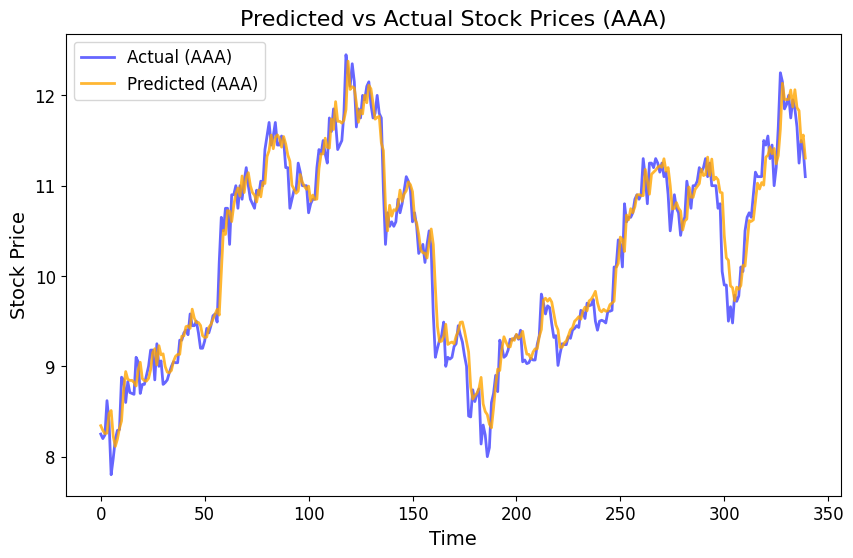

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s, loss=0.00585]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
RMSE: 0.6867067439780488
MAE: 0.4875456406176092
MAPE: 4.552218034881402
R-squared: -21.60522338581057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.92it/s, loss=0.00434]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step
RMSE: 0.1760133720552308
MAE: 0.1473483642935754
MAPE: 1.3769286248175046
R-squared: -0.3075476504248198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s, loss=0.00323]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
RMSE: 0.5587986743215592
MAE: 0.49227793613821264
MAPE: 5.126744600088684
R-squared: -3.455214476474592
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.00337]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
RMSE: 0.2993437841356578
MAE: 0.26703719377890206
MAPE: 2.922077064598975
R-squared: -0.7107126532802339
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s, loss=0.00287]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
RMSE: 0.13538199425673034
MAE: 0.08854088698327525
MAPE: 1.015317029826969
R-squared: 0.11883248226301335
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock AAM: 0.18454756065206063
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


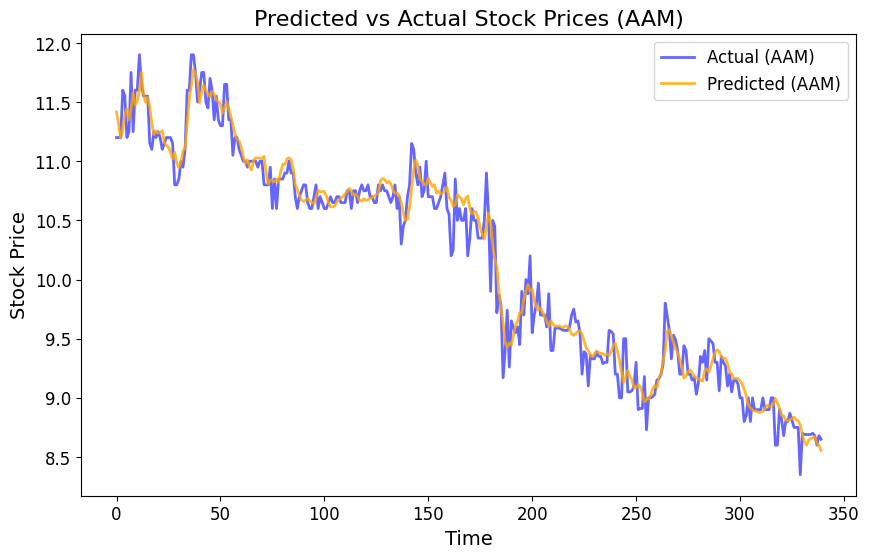

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s, loss=0.000887]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
RMSE: 0.9369019509609928
MAE: 0.6948569356799128
MAPE: 10.460521156760958
R-squared: -0.5235176539283011
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s, loss=0.00251]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step
RMSE: 0.37686431887552413
MAE: 0.3490792757272724
MAPE: 5.851927065296112
R-squared: -0.45823971047592016
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s, loss=0.00256]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
RMSE: 0.12218927560593197
MAE: 0.10049750784039531
MAPE: 2.059683872569748
R-squared: -0.004324084713957177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s, loss=0.00197]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
RMSE: 0.08281625342993708
MAE: 0.06533841800689714
MAPE: 1.211415866675124
R-squared: 0.6024673265322016
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s, loss=0.00158]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
RMSE: 0.10370670897425661
MAE: 0.08011877346038801
MAPE: 1.7257996965319187
R-squared: 0.6164301981353528
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock AAT: 0.2104711625895145
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


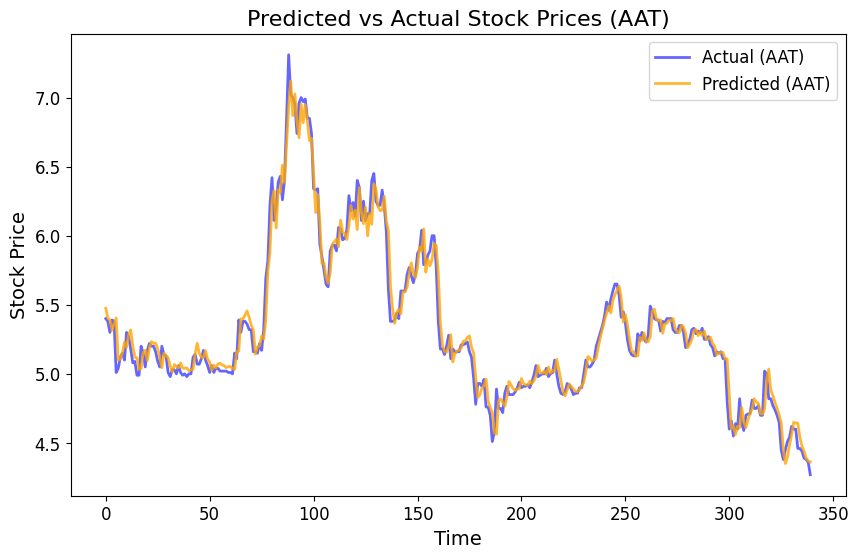

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s, loss=0.00127]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step
RMSE: 2.7720888427429613
MAE: 2.639584908604621
MAPE: 18.68231000227857
R-squared: -2.6761234477354594
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s, loss=0.00213]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
RMSE: 0.5730461890884956
MAE: 0.40157557374238995
MAPE: 2.802610415308248
R-squared: 0.2988816294237223
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s, loss=0.00222]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
RMSE: 1.0173391169314427
MAE: 0.688291279137134
MAPE: 4.288971767307208
R-squared: 0.5443582346982254
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s, loss=0.0023]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step
RMSE: 0.29992776446301195
MAE: 0.24651555550098414
MAPE: 1.8855725842776374
R-squared: 0.35340395901459754
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s, loss=0.00178]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
RMSE: 0.810192388276882
MAE: 0.5749566409289845
MAPE: 4.041744110736781
R-squared: 0.497577614878144
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock ABR: 1.9588411471290563
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


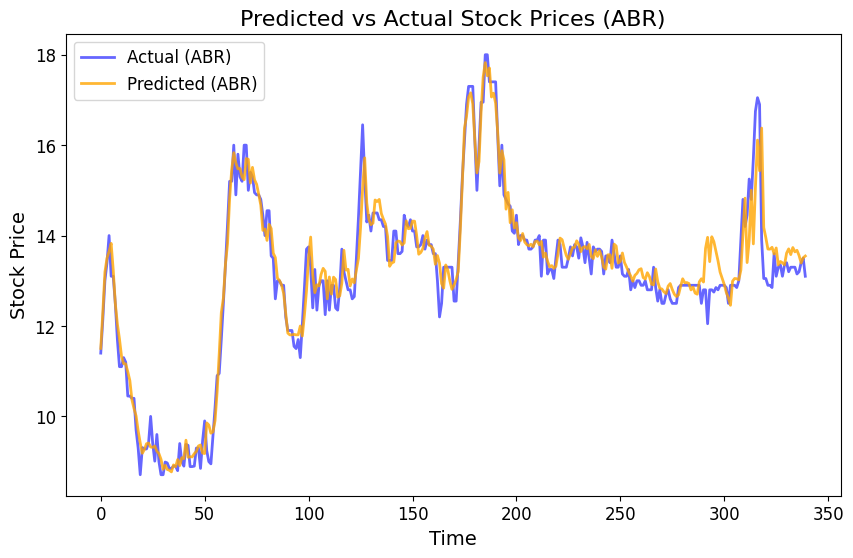

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s, loss=0.00137]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
RMSE: 0.396574604352832
MAE: 0.32328253953531433
MAPE: 4.664418407771904
R-squared: 0.652287045617336
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s, loss=0.00189]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step
RMSE: 1.3988476449555898
MAE: 1.3320306373126811
MAPE: 16.930791229148056
R-squared: -5.250529453713425
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s, loss=0.00288]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step
RMSE: 0.2159116241484459
MAE: 0.1504674977473915
MAPE: 2.792217091502025
R-squared: 0.15603884733074214
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s, loss=0.00236]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step
RMSE: 0.061738203606340906
MAE: 0.045260286103934136
MAPE: 0.7590131357260157
R-squared: 0.5721022946829434
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s, loss=0.00201]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step
RMSE: 0.10700142201635551
MAE: 0.0862140324339267
MAPE: 1.6439225782640583
R-squared: 0.5425299008928819
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE for stock ABS: 0.4351849780311771
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


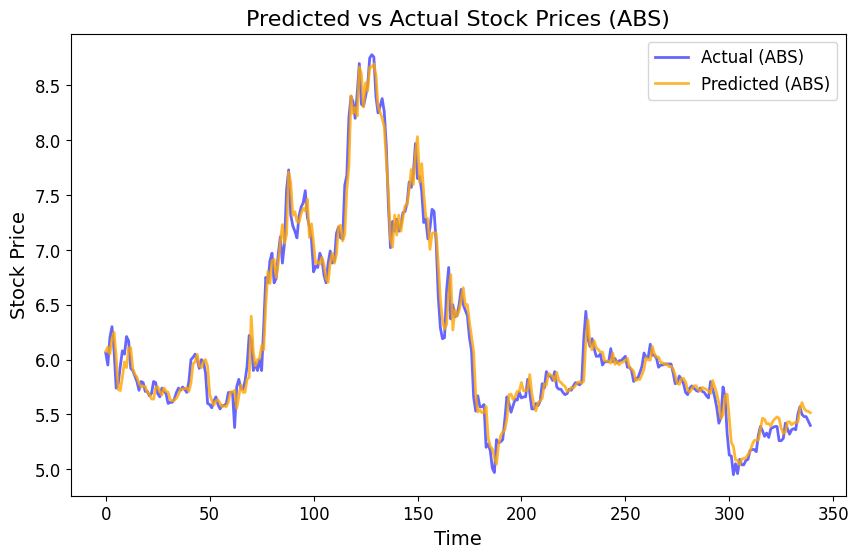

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s, loss=0.0082]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
RMSE: 0.8576231207982845
MAE: 0.7648059251997625
MAPE: 2.3816399757104247
R-squared: -0.14003053222070694
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s, loss=0.00496]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
RMSE: 2.7342093653727115
MAE: 2.35344843806699
MAPE: 6.73562441241029
R-squared: -3.34882829957379
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s, loss=0.00409]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step
RMSE: 1.3236142450225161
MAE: 1.0791951622813936
MAPE: 3.051252188700269
R-squared: -0.6031520960145724
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s, loss=0.00449]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
RMSE: 2.4479484250086094
MAE: 2.1194970564357956
MAPE: 5.820580459579055
R-squared: -4.456239549750412
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s, loss=0.00486]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
RMSE: 0.7841925349513105
MAE: 0.6101049090176826
MAPE: 1.7619833996218839
R-squared: 0.26257267247826643
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE for stock ABT: 3.3141564728043305
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


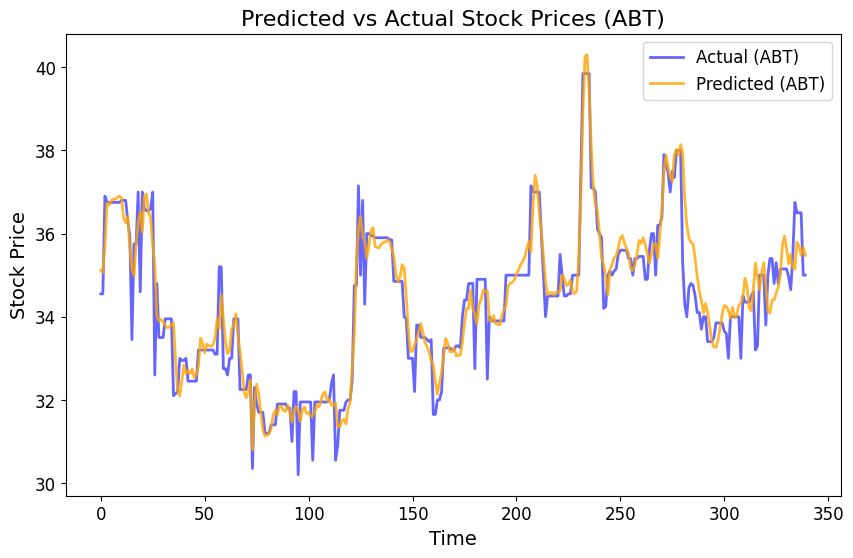

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s, loss=0.00348]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
RMSE: 1.4215770289773717
MAE: 1.1265481917746365
MAPE: 5.080750364049312
R-squared: 0.24730023886264096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s, loss=0.00306]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
RMSE: 0.8316082594761177
MAE: 0.6600337230693546
MAPE: 2.882213688207127
R-squared: -1.4572309643717394
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s, loss=0.0017]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
RMSE: 0.4795078239960909
MAE: 0.3757794542610645
MAPE: 1.6849351076307366
R-squared: -0.055955696884369965
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s, loss=0.0017]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step
RMSE: 2.913560805962861
MAE: 2.7367895445786417
MAPE: 10.062932530986037
R-squared: -10.746104861212594
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s, loss=0.00206]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step
RMSE: 1.1273317383133148
MAE: 0.8351218710094693
MAPE: 3.0760217068206774
R-squared: 0.5371845188666036
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE for stock ACB: 2.540418943613994
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


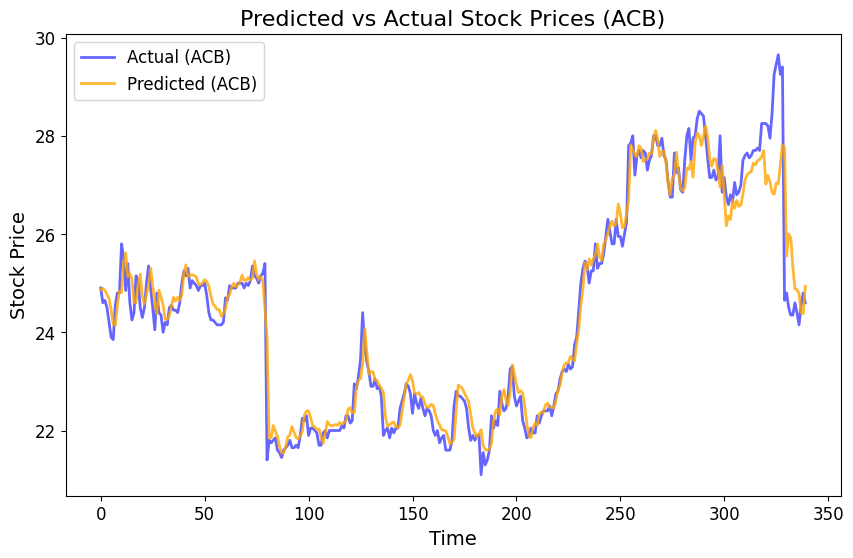

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.38it/s, loss=0.00609]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
RMSE: 1.5505301077794875
MAE: 1.5035612934827818
MAPE: 10.852158517016557
R-squared: -58.272387753134964
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s, loss=0.00281]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step
RMSE: 0.5329476882517005
MAE: 0.4625411021709439
MAPE: 3.5444750068297775
R-squared: -0.9188193778944911
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.82it/s, loss=0.00158]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
RMSE: 0.36275087221293356
MAE: 0.3064169720001516
MAPE: 2.6966869077598554
R-squared: 0.503862021712719
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s, loss=0.00189]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step
RMSE: 0.18610744379187963
MAE: 0.16758953325450401
MAPE: 1.381371980524564
R-squared: 0.5680962589385374
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s, loss=0.0014]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
RMSE: 0.39152061358503404
MAE: 0.284838156327605
MAPE: 2.0099148283994435
R-squared: 0.16955542259549838
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE for stock ACC: 0.6015378840662988
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


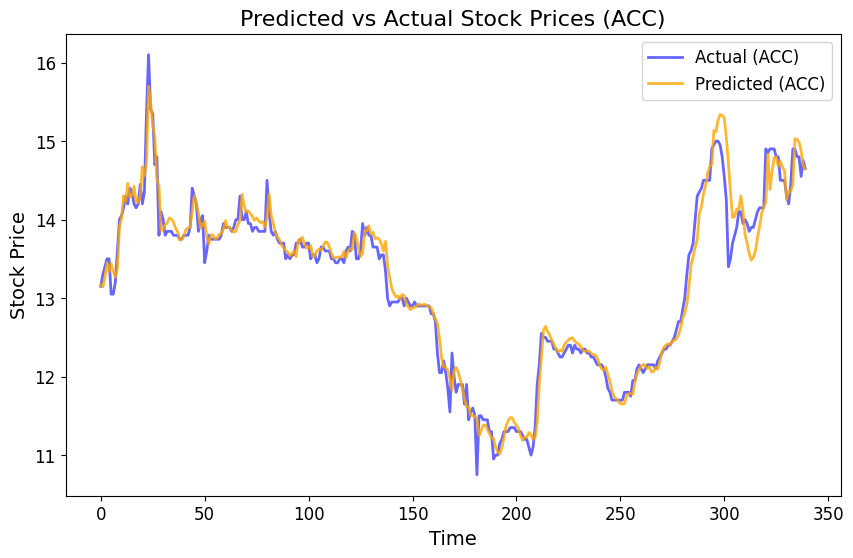

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s, loss=0.00236]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
RMSE: 1.1866365138923074
MAE: 0.9912834902107687
MAPE: 2.479209648835946
R-squared: -0.23267364393912726
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s, loss=0.00166]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
RMSE: 1.7612514172463825
MAE: 1.4537424375861914
MAPE: 3.3184573329506084
R-squared: -0.9191150279914126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.00276]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
RMSE: 0.6101525034991171
MAE: 0.4665030102431761
MAPE: 1.2269794094837454
R-squared: -0.13305382062731153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s, loss=0.00239]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
RMSE: 0.7285540844611982
MAE: 0.6135928903520076
MAPE: 1.5624464759883767
R-squared: 0.8481716238808794
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s, loss=0.00185]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
RMSE: 1.003551052683946
MAE: 0.6364474685490128
MAPE: 1.4855118883009837
R-squared: 0.8867081600065745
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock ACG: 1.284060923541854
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


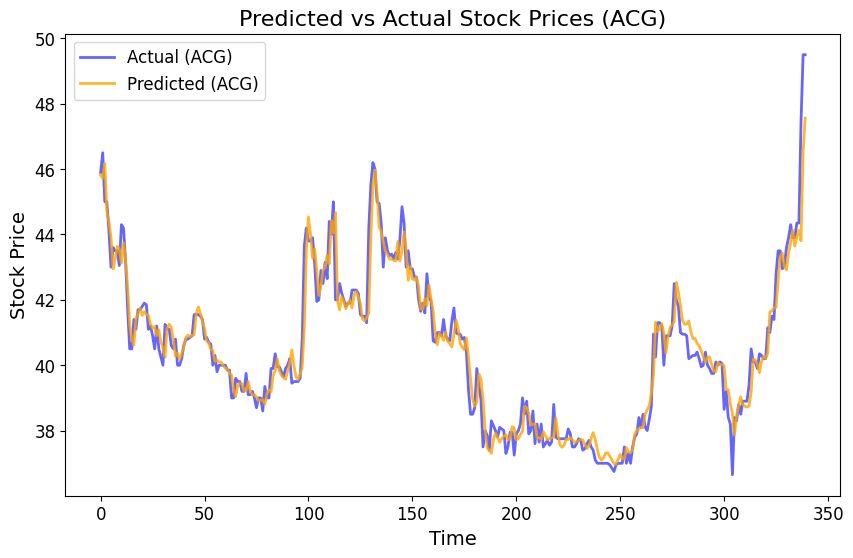

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.78it/s, loss=0.00371]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
RMSE: 0.6735603492463137
MAE: 0.5988455875217917
MAPE: 4.805041137811966
R-squared: 0.3269024208422786
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s, loss=0.00259]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
RMSE: 0.597305402905414
MAE: 0.4670060101151467
MAPE: 3.2757084705979898
R-squared: 0.422390987405867
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s, loss=0.00357]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
RMSE: 0.2739658299367124
MAE: 0.2093225941061973
MAPE: 1.6816957429917636
R-squared: -0.5932027668290745
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s, loss=0.00301]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
RMSE: 0.25259775492766035
MAE: 0.17860964044928518
MAPE: 1.3974485962139878
R-squared: 0.7959199558787962
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s, loss=0.00264]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
RMSE: 0.1313841490755379
MAE: 0.09219651639461524
MAPE: 0.7318515965205735
R-squared: 0.533386190145547
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock ACL: 0.19331639696250483
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


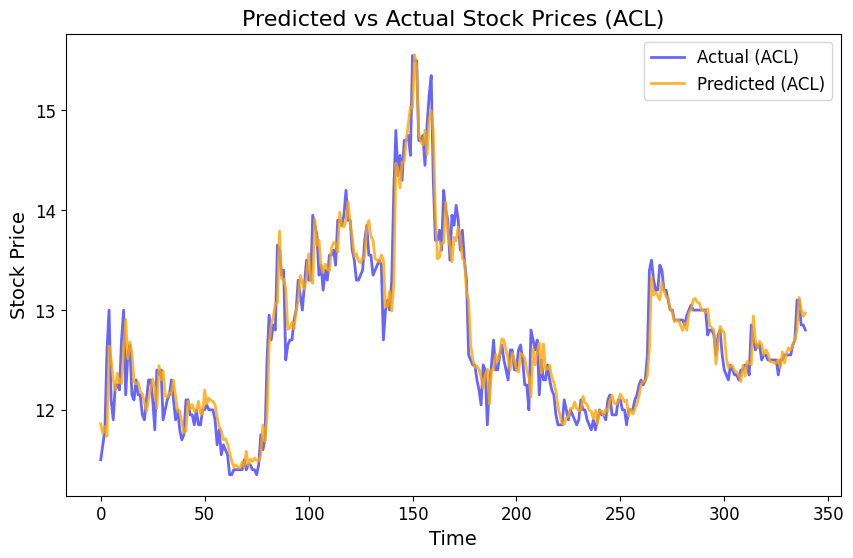

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.82it/s, loss=0.00332]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
RMSE: 1.2302103413462002
MAE: 0.9482529440522196
MAPE: 2.653680967017814
R-squared: 0.3025223664353095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s, loss=0.00527]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
RMSE: 2.377479024320383
MAE: 1.5993055871129023
MAPE: 5.090679492755125
R-squared: -0.3292669425338206
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s, loss=0.00326]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
RMSE: 0.866525224262683
MAE: 0.7362439298629759
MAPE: 3.0515296491969943
R-squared: 0.5466191633058295
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s, loss=0.00201]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
RMSE: 0.31743928643973635
MAE: 0.2578008425235745
MAPE: 1.290539611042272
R-squared: 0.6529739110620095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s, loss=0.00187]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
RMSE: 0.6164584001402054
MAE: 0.49404640842229197
MAPE: 2.9347516316419844
R-squared: 0.15131269252767177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock ADG: 1.6794957238001635
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


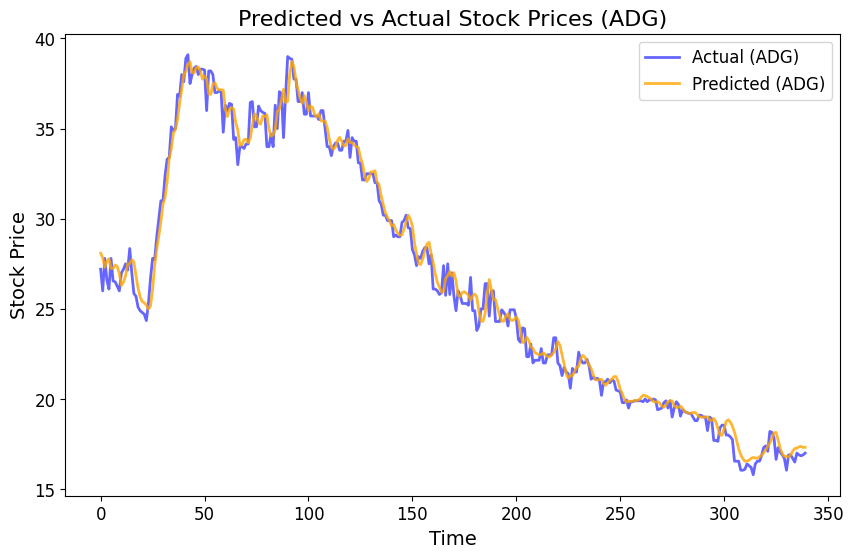

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s, loss=0.000702]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
RMSE: 0.7908176352018667
MAE: 0.7043473588302733
MAPE: 3.7623022044109
R-squared: -3.991052551771353
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.00113]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
RMSE: 0.8723910952311834
MAE: 0.7362465068930759
MAPE: 3.899885822087643
R-squared: -9.255715388756274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.17it/s, loss=0.000859]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
RMSE: 1.7475762427708934
MAE: 1.6411771392449737
MAPE: 7.201360960335404
R-squared: -4.926994294747113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.17it/s, loss=0.00138]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
RMSE: 0.9708601062526128
MAE: 0.8737194493413005
MAPE: 3.6704371939452884
R-squared: -0.5943029570775371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s, loss=0.00203]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
RMSE: 0.8991077056473001
MAE: 0.7860210031270962
MAPE: 2.916298702133425
R-squared: 0.2677416133582874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MSE for stock ADP: 1.238289098349871
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


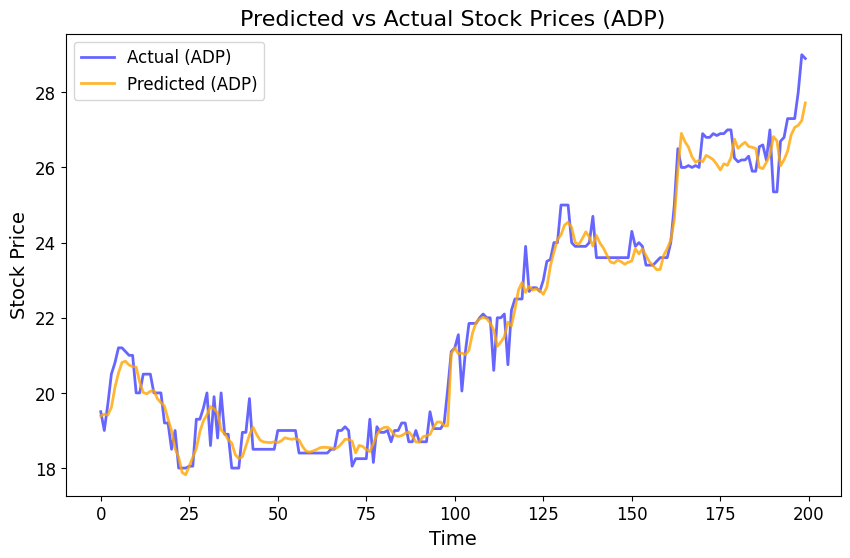

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.00125]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
RMSE: 3.3536095194087956
MAE: 2.87543473065272
MAPE: 18.808552105910316
R-squared: -6.408898804396362
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s, loss=0.00256]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step
RMSE: 0.6837981252167158
MAE: 0.5218399869054557
MAPE: 3.318630157969079
R-squared: 0.2149348846426018
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.17it/s, loss=0.00285]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
RMSE: 0.39421396422979815
MAE: 0.32654062332212874
MAPE: 2.470616096756839
R-squared: 0.1644911312162769
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s, loss=0.00225]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
RMSE: 0.26701511948564627
MAE: 0.22236355809867345
MAPE: 1.703578037494017
R-squared: 0.2491957650067016
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s, loss=0.00215]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
RMSE: 0.3676965499682818
MAE: 0.2595285947397351
MAPE: 1.904573562315559
R-squared: 0.8605315113899555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock ADS: 2.4152358322410943
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


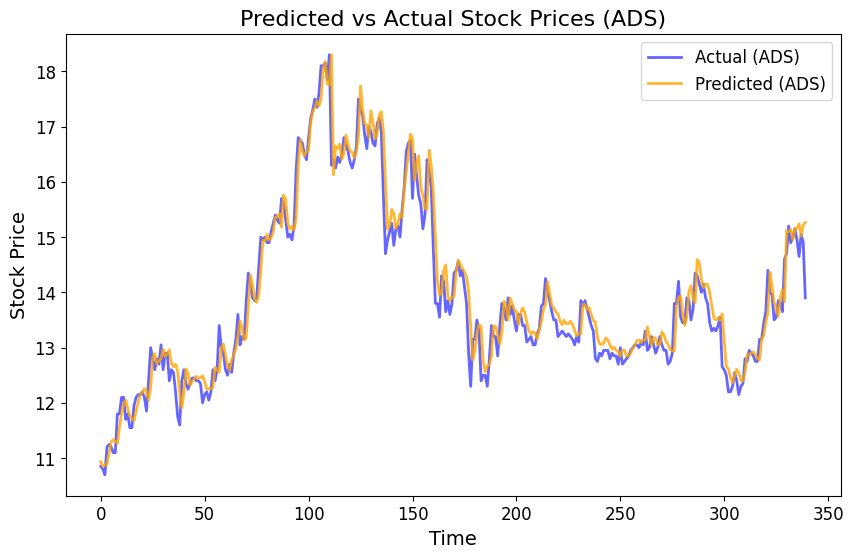

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.66it/s, loss=0.00227]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
RMSE: 0.5389881896187431
MAE: 0.4597899484634402
MAPE: 1.6361699537738823
R-squared: -0.17348185655699466
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.08it/s, loss=0.00168]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
RMSE: 1.4785740649772758
MAE: 1.1805062294006343
MAPE: 3.5617469275527744
R-squared: -0.21095013934239537
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s, loss=0.00218]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step
RMSE: 2.341540480651449
MAE: 2.260505385398865
MAPE: 8.906101046927432
R-squared: -6.711409033093413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s, loss=0.00179]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
RMSE: 0.41467744936208506
MAE: 0.3073970930278299
MAPE: 1.3092129693147834
R-squared: 0.8087233749953602
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s, loss=0.00118]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
RMSE: 0.9964400621261564
MAE: 0.8467331560701133
MAPE: 3.4709738737559377
R-squared: 0.7946935480888768
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock AGG: 1.8248703082241513
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


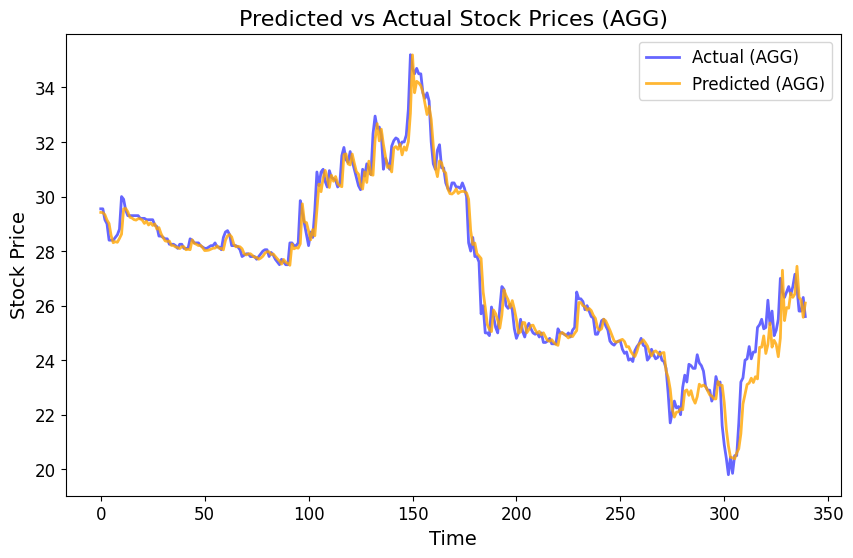

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s, loss=0.000355]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
RMSE: 0.4380455489939528
MAE: 0.38842481069266743
MAPE: 6.842809306492166
R-squared: -0.7477993823749249
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s, loss=0.000427]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 2.352698593813969
MAE: 1.93069617651403
MAPE: 19.192126138967268
R-squared: -0.570209060626556
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s, loss=0.00141]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
RMSE: 0.5552344781160343
MAE: 0.5552344781160343
MAPE: 8.841313345796726
R-squared: 0.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s, loss=0.000685]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
RMSE: 0.013838981539009865
MAE: 0.013838981539009865
MAPE: 0.22036594807340548
R-squared: 0.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s, loss=0.000514]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
RMSE: 0.1409716489602399
MAE: 0.09740657621249542
MAPE: 2.0587258769426624
R-squared: 0.6551920567264837
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock AGM: 1.2110848850474065
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


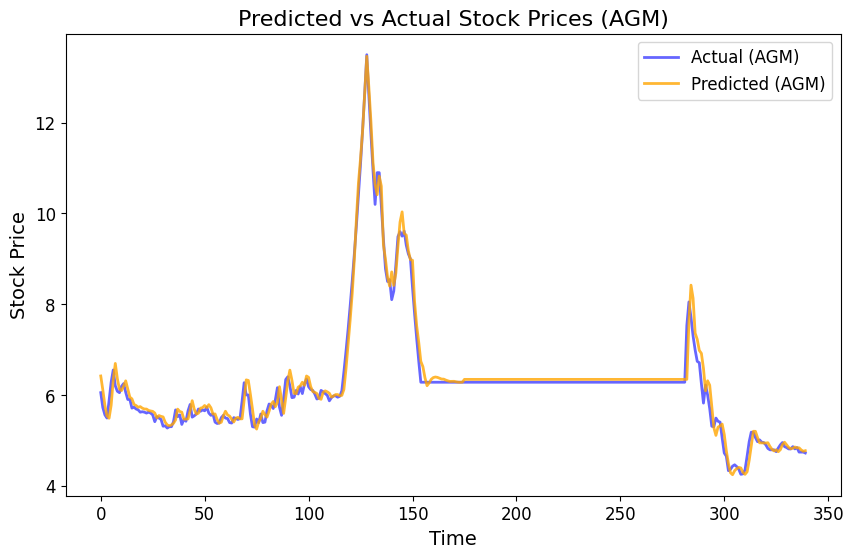

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.000192]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
RMSE: 8.613098169912838
MAE: 8.271626743078233
MAPE: 63.23620587808533
R-squared: -115.55475119519964
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s, loss=0.000712]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
RMSE: 1.1154443150560682
MAE: 0.9391390028595928
MAPE: 5.360744449137907
R-squared: 0.4955153459879177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s, loss=0.000872]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
RMSE: 0.7776496685544383
MAE: 0.5174989694356917
MAPE: 3.71977057270908
R-squared: 0.5934596010132082
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s, loss=0.00126]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
RMSE: 0.5161421184606264
MAE: 0.39073710620403396
MAPE: 2.107241855951238
R-squared: 0.9056475957925598
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s, loss=0.00122]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
RMSE: 0.6715869533227422
MAE: 0.4939542573690418
MAPE: 2.4979606658452376
R-squared: 0.7949028985160642
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock AGR: 15.350369366774395
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


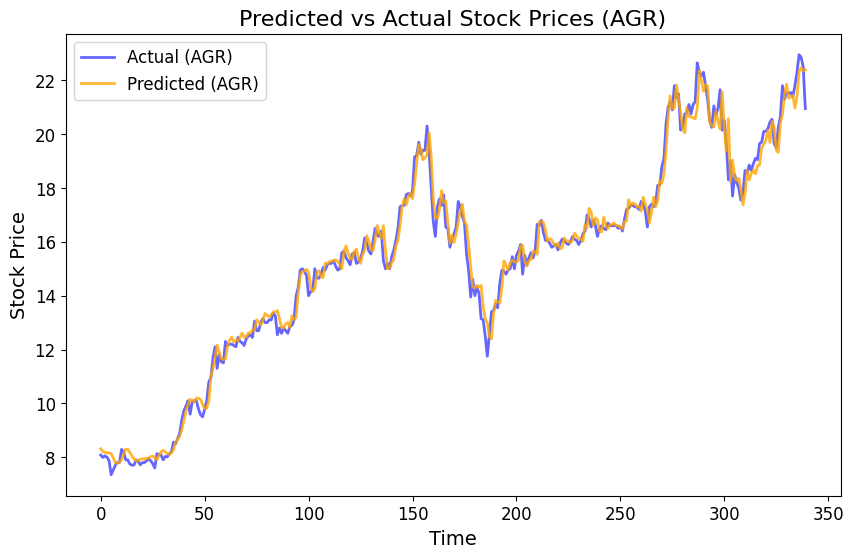

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s, loss=0.000449]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
RMSE: 0.1031046342849733
MAE: 0.1031046342849733
MAPE: 8.66425498193053
R-squared: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s, loss=0.00389]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
RMSE: 0.08108979314565667
MAE: 0.08108979314565667
MAPE: 7.305386769878979
R-squared: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.98it/s, loss=0.00333]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
RMSE: 0.0025099273398518918
MAE: 0.0025099273398518918
MAPE: 0.22611958016683706
R-squared: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.15it/s, loss=0.00218]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
RMSE: 0.00017595492303379423
MAE: 0.00017595492303379423
MAPE: 0.01585179486790939
R-squared: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s, loss=0.00116]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
RMSE: 0.0029492203518748372
MAE: 0.0029492203518748372
MAPE: 0.26569552719593126
R-squared: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
MSE for stock AMD: 0.0034442297519027333


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


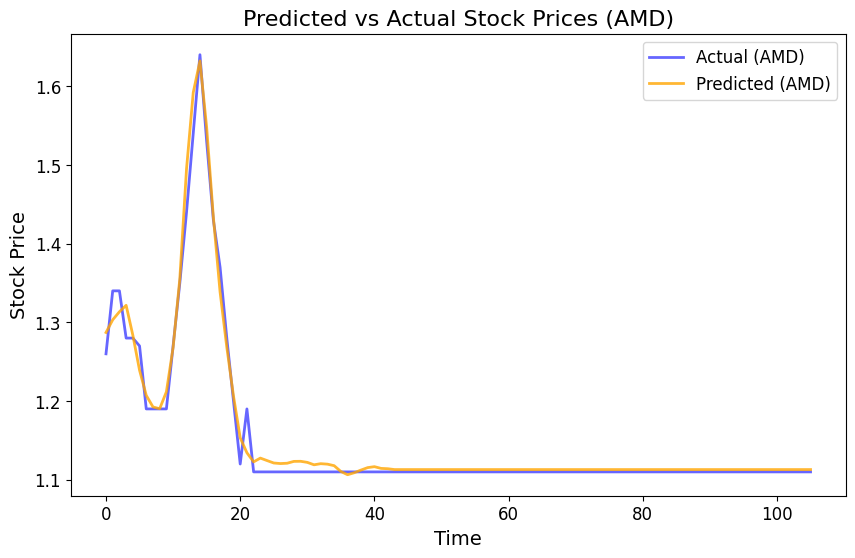

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.88it/s, loss=0.00455]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
RMSE: 3.057428433134349
MAE: 2.869780230820178
MAPE: 8.445555674615486
R-squared: -5.443646616360031
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s, loss=0.00331]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
RMSE: 1.749534746841242
MAE: 1.4038594727963196
MAPE: 3.9014552017998962
R-squared: 0.3021824910449805
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.004]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
RMSE: 1.4267039595745294
MAE: 0.956071116179228
MAPE: 3.344864519771331
R-squared: 0.42219296200704226
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.56it/s, loss=0.0038]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
RMSE: 0.7118239263202272
MAE: 0.5769723234325664
MAPE: 1.8359315780113006
R-squared: 0.8931802865624908
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s, loss=0.00251]


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step  
RMSE: 0.7893814333367917
MAE: 0.6396205310896036
MAPE: 2.051756396957342
R-squared: 0.853224759209464
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock ANV: 3.1148081983575286
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


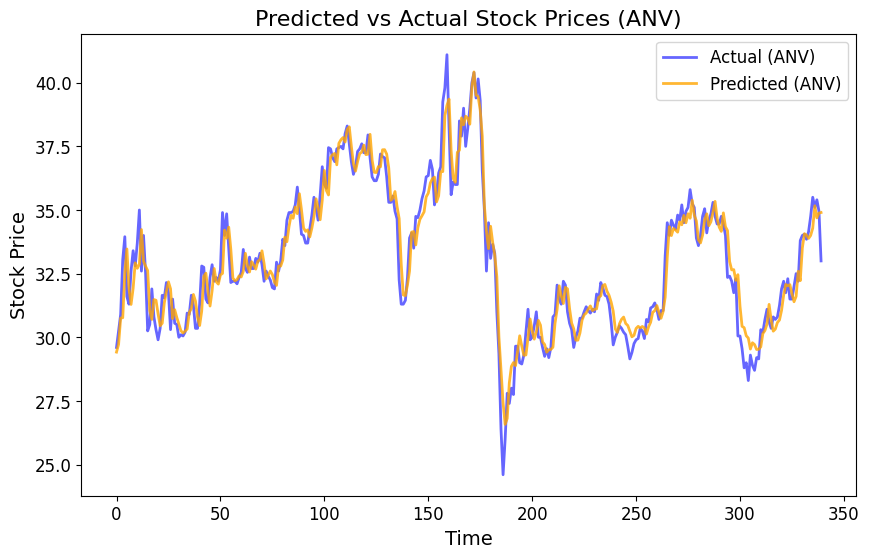

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s, loss=0.00414]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
RMSE: 0.6959636489037327
MAE: 0.6261729174677069
MAPE: 5.126664241586621
R-squared: -1.4843384161959343
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s, loss=0.00417]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
RMSE: 0.2751115523338029
MAE: 0.21713679783484507
MAPE: 1.791829016670133
R-squared: -0.3602307024603726
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s, loss=0.00256]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
RMSE: 0.9272170148356003
MAE: 0.894820698376965
MAPE: 8.770063561149529
R-squared: -11.031085695685379
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s, loss=0.0023]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
RMSE: 0.36753374567278563
MAE: 0.27491932609502046
MAPE: 3.1576712346453926
R-squared: 0.6618864951489333
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.00152]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
RMSE: 0.5496729357438322
MAE: 0.4151797444022755
MAPE: 5.948236478130312
R-squared: 0.13845731595625455
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock APC: 0.3714009099842131
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


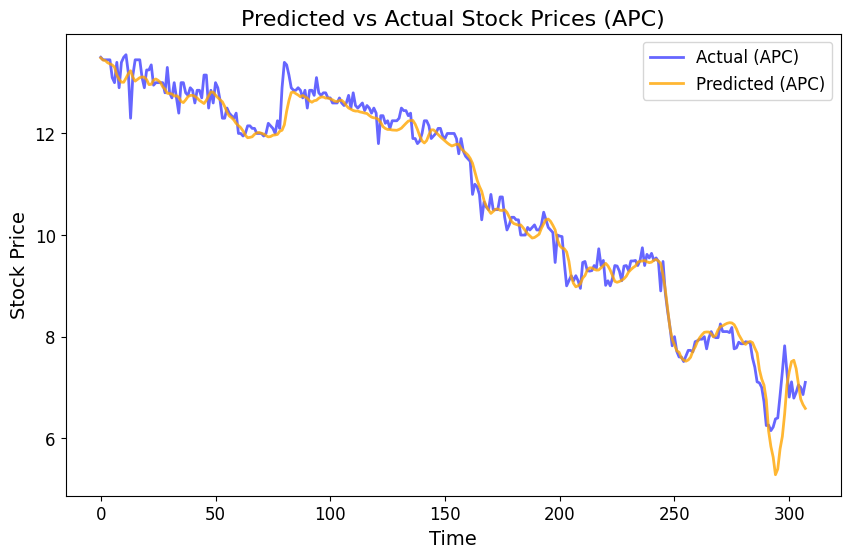

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s, loss=0.000245]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
RMSE: 0.2884802124985519
MAE: 0.24789690434932726
MAPE: 3.2550630686787563
R-squared: -2.248561368707622
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s, loss=0.000337]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
RMSE: 0.7439499904370694
MAE: 0.607438542053103
MAPE: 5.757466862408147
R-squared: 0.169169253982016
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s, loss=0.00103]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step
RMSE: 0.6385678184657485
MAE: 0.5592557162567979
MAPE: 5.667028397562706
R-squared: -0.4100671502576383
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s, loss=0.000619]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
RMSE: 0.40009469737872916
MAE: 0.3391341920197001
MAPE: 2.3669818256739807
R-squared: 0.7399362058883445
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s, loss=0.000957]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
RMSE: 0.525298985186052
MAE: 0.4318151118457326
MAPE: 3.095356923445389
R-squared: -0.12228074184506377
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock APG: 0.29609321415254075
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


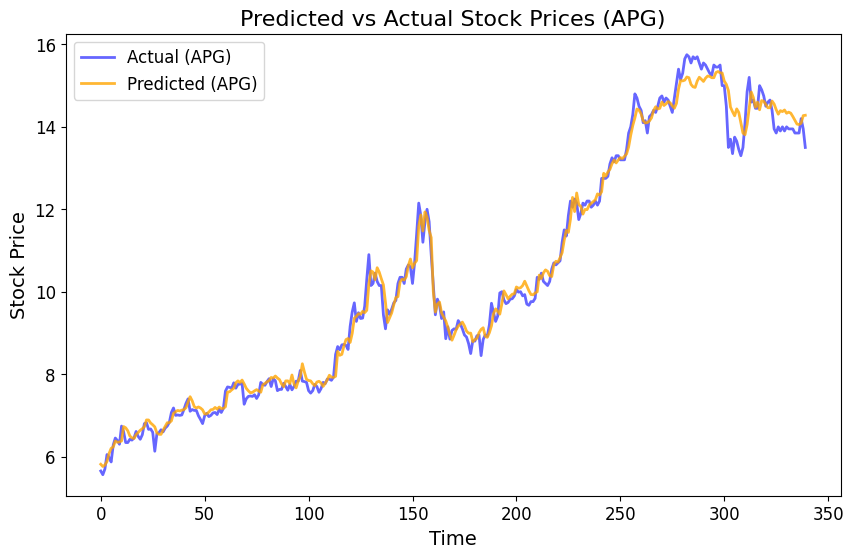

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.94it/s, loss=0.000626]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
RMSE: 2.904729020570105
MAE: 2.5244465630128987
MAPE: 28.47142803341604
R-squared: -124.85883863038178
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s, loss=0.0028]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
RMSE: 0.34652020083074236
MAE: 0.27122209560871086
MAPE: 2.8238807971798563
R-squared: 0.4295258589268689
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s, loss=0.00233]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
RMSE: 0.31538319206721677
MAE: 0.25004277259111396
MAPE: 3.4211276021507615
R-squared: -0.774168831705103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.67it/s, loss=0.002]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step
RMSE: 0.1455066191622204
MAE: 0.10512887232005605
MAPE: 1.2679591791768312
R-squared: 0.8250196313453382
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s, loss=0.00185]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
RMSE: 0.49397619726448855
MAE: 0.38085586628317836
MAPE: 3.955099570095523
R-squared: 0.8061966284097258
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock APH: 1.7844356300096698
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


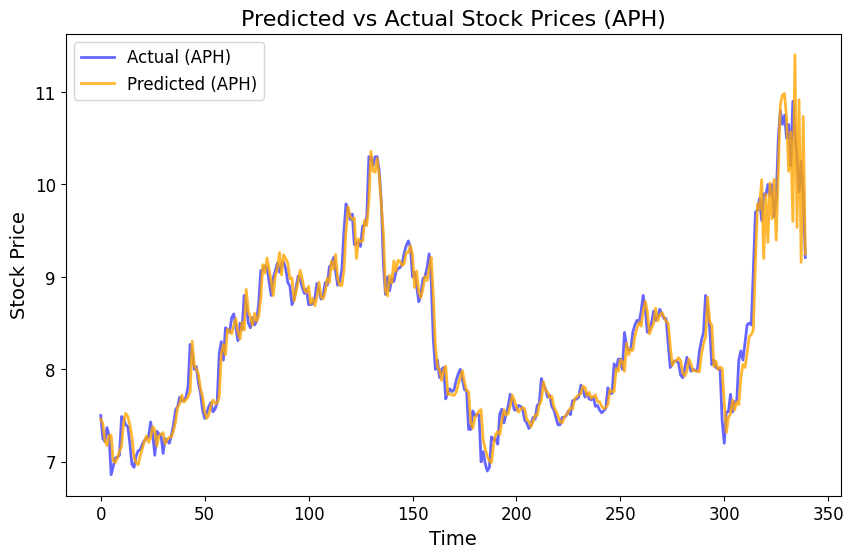

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.06it/s, loss=0.00482]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 0.9011023907622381
MAE: 0.84533457159996
MAPE: 3.695557223094354
R-squared: -7.814552071510104
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s, loss=0.00329]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
RMSE: 0.4352676318652165
MAE: 0.3031695997714997
MAPE: 1.3107075065998786
R-squared: -0.17475065167913972
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s, loss=0.00338]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
RMSE: 0.37468788977847495
MAE: 0.30305494859814647
MAPE: 1.3454877344318337
R-squared: 0.16433142572146409
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s, loss=0.00218]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step
RMSE: 0.45009156797868877
MAE: 0.31930774994194505
MAPE: 1.5092794601300832
R-squared: -0.2195609910726979
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s, loss=0.00196]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
RMSE: 0.5738224613361856
MAE: 0.4534497855231165
MAPE: 2.30079522966274
R-squared: -1.3659127995162041
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock ASG: 0.33473781628661087
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


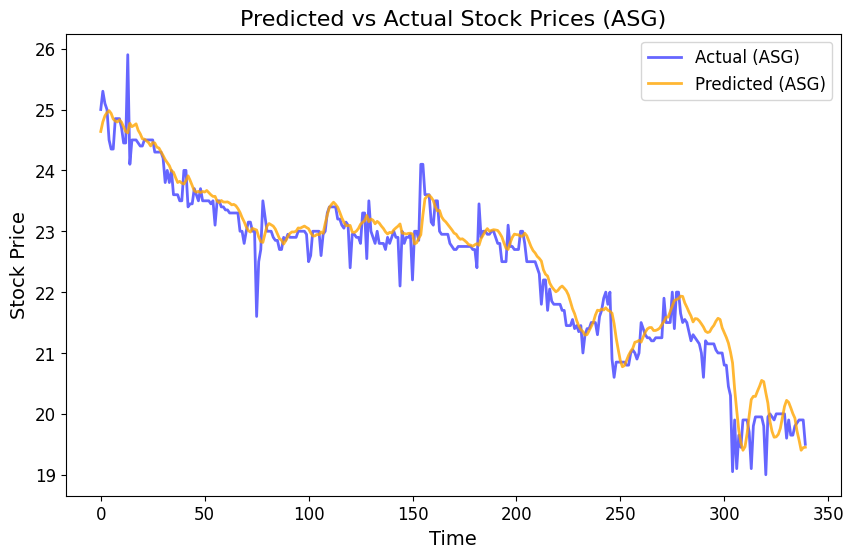

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.000959]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
RMSE: 0.8400952892390986
MAE: 0.6843631380423908
MAPE: 6.787652552018946
R-squared: 0.06881296874394904
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s, loss=0.00197]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
RMSE: 0.5262088089767739
MAE: 0.4694876627773053
MAPE: 4.231423905543587
R-squared: 0.006287649389758565
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s, loss=0.00206]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
RMSE: 0.26538896462045675
MAE: 0.19608377688564338
MAPE: 2.1560019481025696
R-squared: 0.7645815909005831
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s, loss=0.00199]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
RMSE: 0.2709629198457772
MAE: 0.2146545385569337
MAPE: 1.9445445951991602
R-squared: 0.689970055448105
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s, loss=0.0021]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 0.26984579212168397
MAE: 0.22807871006429264
MAPE: 1.9544491657679206
R-squared: 0.6570404096398499
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock ASM: 0.23986495272918515
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


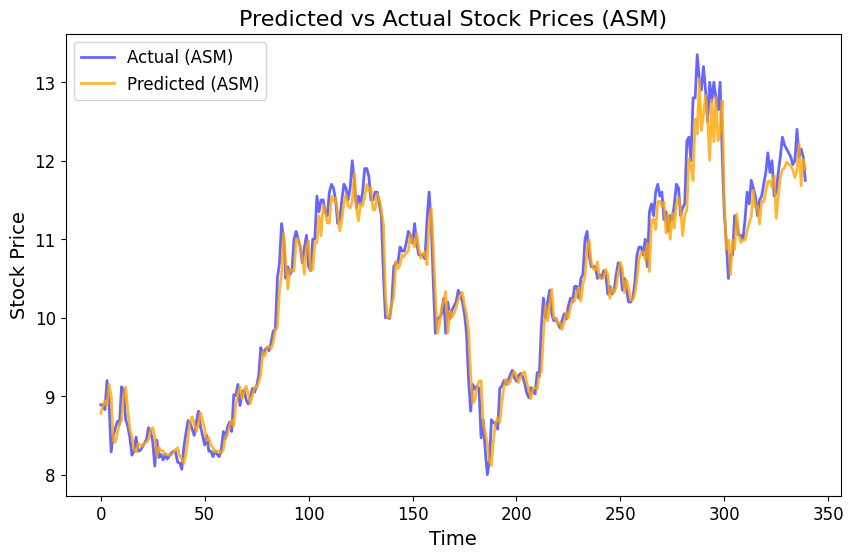

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.00336]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
RMSE: 0.4192045053090018
MAE: 0.38793310827016797
MAPE: 6.290897383571218
R-squared: -2.1237188375557445
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.00379]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
RMSE: 0.2712790061428915
MAE: 0.20037373632192654
MAPE: 3.2860988814507204
R-squared: -0.39710273360789317
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.85it/s, loss=0.00339]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
RMSE: 0.1895914716931246
MAE: 0.15001212063431776
MAPE: 2.8577363868724692
R-squared: -0.09240360479539911
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s, loss=0.00251]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
RMSE: 0.06974572577857875
MAE: 0.047076465636491684
MAPE: 0.9513464212015486
R-squared: -0.2676340043012342
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s, loss=0.00171]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
RMSE: 0.11845531239582778
MAE: 0.08241411483287817
MAPE: 1.8435264508005038
R-squared: 0.8081820751129383
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock ASP: 0.06083315397663571
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


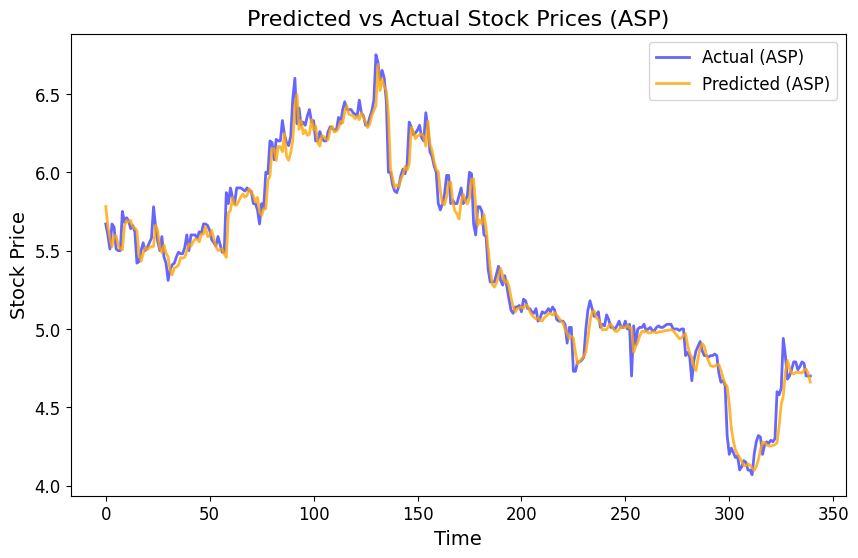

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.54it/s, loss=0.00237]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
RMSE: 5.0187651986545685
MAE: 4.925182335078714
MAPE: 8.145099749264714
R-squared: -21.160956031322726
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.00286]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
RMSE: 0.6330691379989469
MAE: 0.46504836559295554
MAPE: 0.7804128028198379
R-squared: 0.6369366699248284
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s, loss=0.00192]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step
RMSE: 1.5159512100556367
MAE: 1.234986038506031
MAPE: 2.3394564222597607
R-squared: 0.7422894485759134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s, loss=0.0022]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
RMSE: 0.7839861028229292
MAE: 0.6228178048133849
MAPE: 1.081900267542119
R-squared: -0.6742964026681637
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it, loss=0.00192]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 1.8555726410679365
MAE: 1.2795108801126478
MAPE: 2.093196969062584
R-squared: 0.5975721759180761
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock AST: 6.388934551936286
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


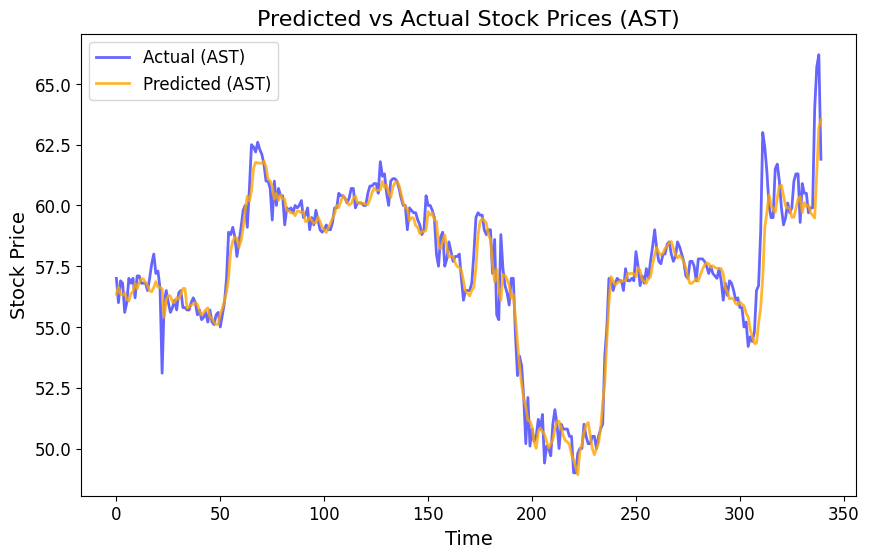

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s, loss=0.000775]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step
RMSE: 3.798267655039842
MAE: 3.6610489075630896
MAPE: 15.703261896219281
R-squared: -23.75143362776245
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s, loss=0.002]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
RMSE: 0.5722037336105366
MAE: 0.41190794900059746
MAPE: 1.9379265928251197
R-squared: 0.7859037158940156
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s, loss=0.00161]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
RMSE: 0.5779295461850305
MAE: 0.45178769826888965
MAPE: 1.7929544448279333
R-squared: 0.7370977185305251
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s, loss=0.0016]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step
RMSE: 0.47221783096287884
MAE: 0.39017611593008106
MAPE: 1.4997893537194
R-squared: 0.8142903680495643
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s, loss=0.00116]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
RMSE: 1.2827030272500366
MAE: 0.7538952432572841
MAPE: 3.1324095701470287
R-squared: 0.7958689284794441
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock BAF: 3.391314717685806
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


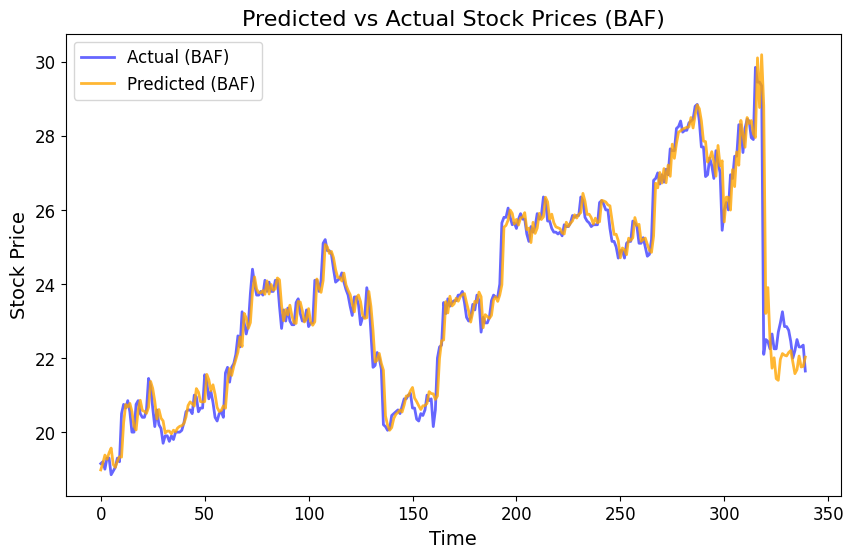

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s, loss=0.00757]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
RMSE: 5.049023958226114
MAE: 4.650990232825283
MAPE: 8.094417265415943
R-squared: -8.822240475742191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.85it/s, loss=0.00727]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
RMSE: 1.6162295560448963
MAE: 1.3721070492267613
MAPE: 2.325478557630128
R-squared: -1.642604445231024
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s, loss=0.00454]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
RMSE: 5.63627531814017
MAE: 5.377747277021414
MAPE: 10.18757066176543
R-squared: -28.08388406021935
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.00375]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
RMSE: 2.972116900880366
MAE: 2.2461937326192816
MAPE: 4.350147542631798
R-squared: -7.290502757523171
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s, loss=0.00302]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step
RMSE: 1.2619286372464293
MAE: 1.0760706496238737
MAPE: 2.166045736125142
R-squared: -1.724052190949069
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock BBC: 14.059676625690358
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


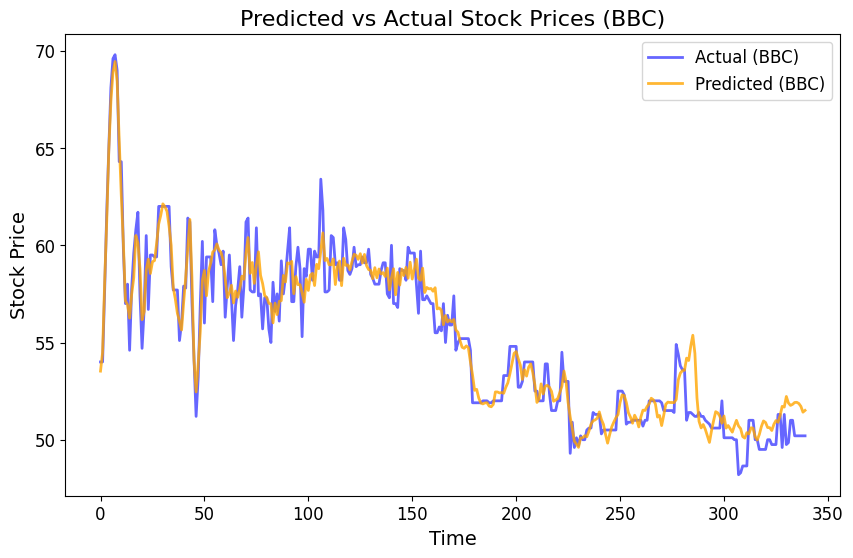

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s, loss=0.00133]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
RMSE: 0.28929031448376424
MAE: 0.23208316052705064
MAPE: 3.619413790584928
R-squared: 0.23382830779231012
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s, loss=0.0021]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
RMSE: 0.2670694529845362
MAE: 0.19662940087914466
MAPE: 2.9520098730246387
R-squared: 0.4868589506582106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.75it/s, loss=0.00336]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step
RMSE: 0.1192380871777496
MAE: 0.08305093529075376
MAPE: 1.4250320156495655
R-squared: -0.1543227716961797
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s, loss=0.00283]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step
RMSE: 0.07228767144039003
MAE: 0.053309805713593984
MAPE: 0.9048230030430865
R-squared: 0.6841532120826845
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s, loss=0.00259]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
RMSE: 0.06847083759615163
MAE: 0.05342302699387069
MAPE: 0.8980356894335687
R-squared: 0.6359414027203063
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock BCE: 0.035829292649755116
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


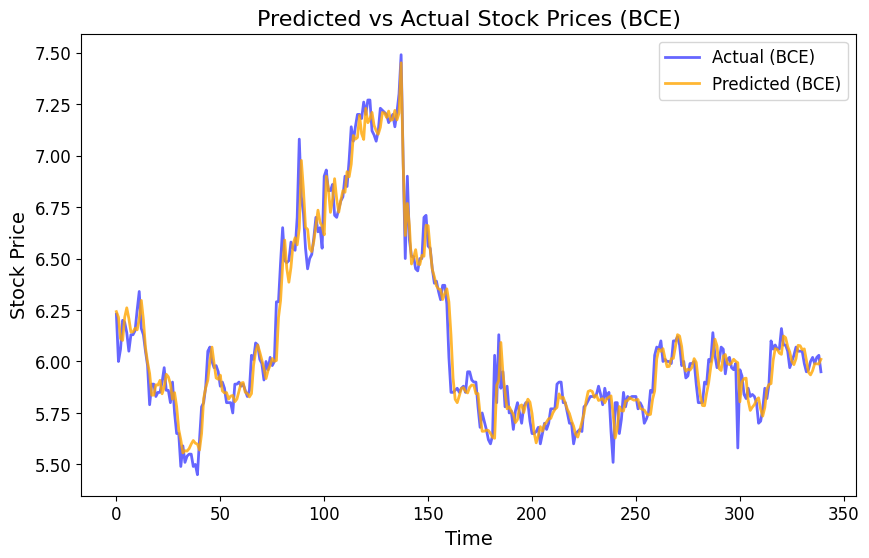

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s, loss=0.000335]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 4.4924991105622345
MAE: 3.7066405701786294
MAPE: 38.924841570578415
R-squared: -53.17771060870917
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.00217]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
RMSE: 0.6880009457632386
MAE: 0.6074517813324928
MAPE: 5.29558441954708
R-squared: -0.6612341199365586
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s, loss=0.00277]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
RMSE: 0.307791774508423
MAE: 0.23719327197223894
MAPE: 2.825948079528088
R-squared: 0.7241078530255676
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.00283]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
RMSE: 0.1546865489487001
MAE: 0.11213903424143798
MAPE: 1.316067020790871
R-squared: 0.37482142654799677
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s, loss=0.00256]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
RMSE: 0.27210972947311957
MAE: 0.199851377785206
MAPE: 2.243906363351921
R-squared: 0.7953191200974997
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock BCG: 4.169720193905643
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


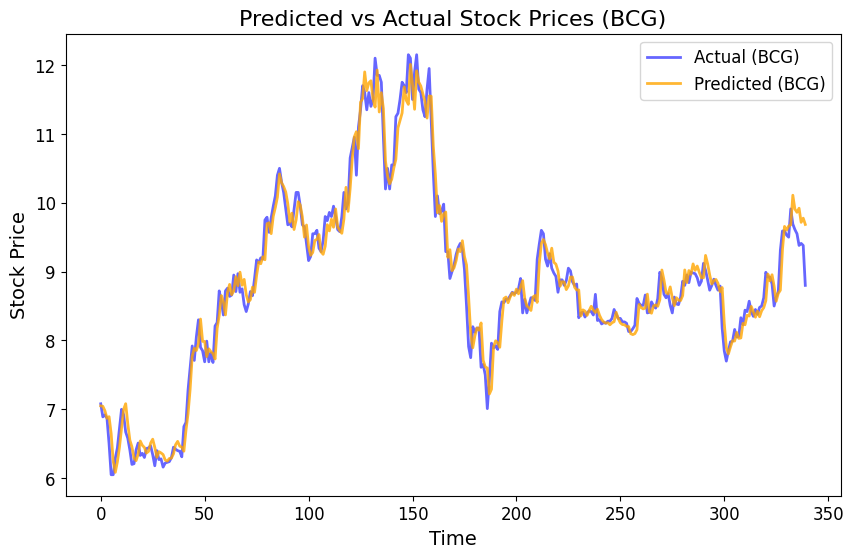

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.52it/s, loss=0.00696]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step
RMSE: 2.8215182798566723
MAE: 2.5022931721806634
MAPE: 3.2038289016002044
R-squared: -1.8844338820334863
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s, loss=0.00458]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
RMSE: 2.791914010587108
MAE: 2.177152088284501
MAPE: 3.079491956268769
R-squared: 0.42687282960803485
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s, loss=0.00302]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step
RMSE: 2.6456224386680445
MAE: 2.3853320284187793
MAPE: 3.9531997359556965
R-squared: -0.2743178254349219
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s, loss=0.002]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
RMSE: 2.4916121180408997
MAE: 1.8474081581085926
MAPE: 2.8550118472900143
R-squared: -0.01730945461175848
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s, loss=0.00162]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
RMSE: 2.006925164286787
MAE: 1.6541770445927981
MAPE: 2.9161411951710634
R-squared: 0.7980701351481644
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock BCM: 6.598189379175519
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


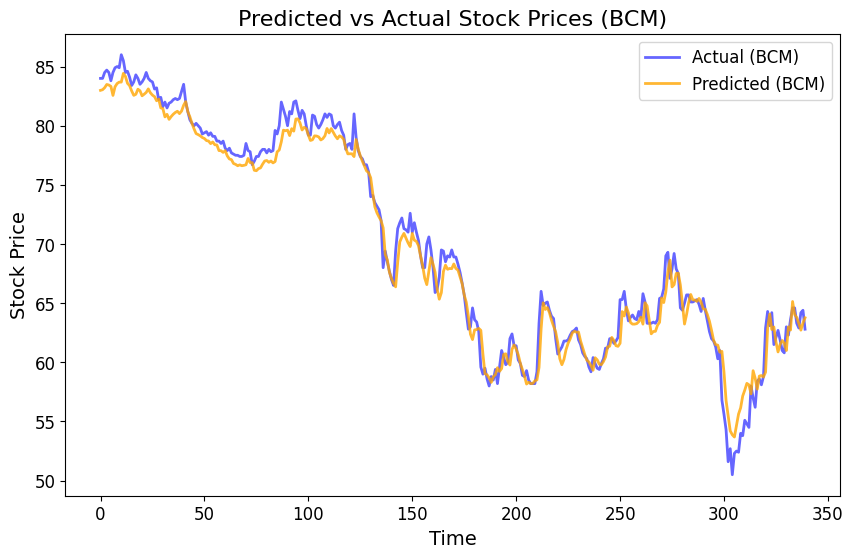

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s, loss=7.33e-5]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
RMSE: 1.6043856799523355
MAE: 1.3307444734801541
MAPE: 7.585419069405661
R-squared: -3.731185851835062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s, loss=0.000198]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
RMSE: 0.9291037720271694
MAE: 0.7708530693966897
MAPE: 3.9565043316024893
R-squared: -1.1578232490787195
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s, loss=0.000276]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
RMSE: 0.9555752877660849
MAE: 0.7408980465680355
MAPE: 3.207442913600516
R-squared: 0.7939655383494131
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.000437]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
RMSE: 1.0949590865829
MAE: 0.8525689587369577
MAPE: 3.0500752253822707
R-squared: 0.6779921361884758
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s, loss=0.000774]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
RMSE: 1.4173525008117709
MAE: 1.2192094215005642
MAPE: 3.47999560251044
R-squared: 0.8908217062201259
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock BFC: 1.5116469745336616
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


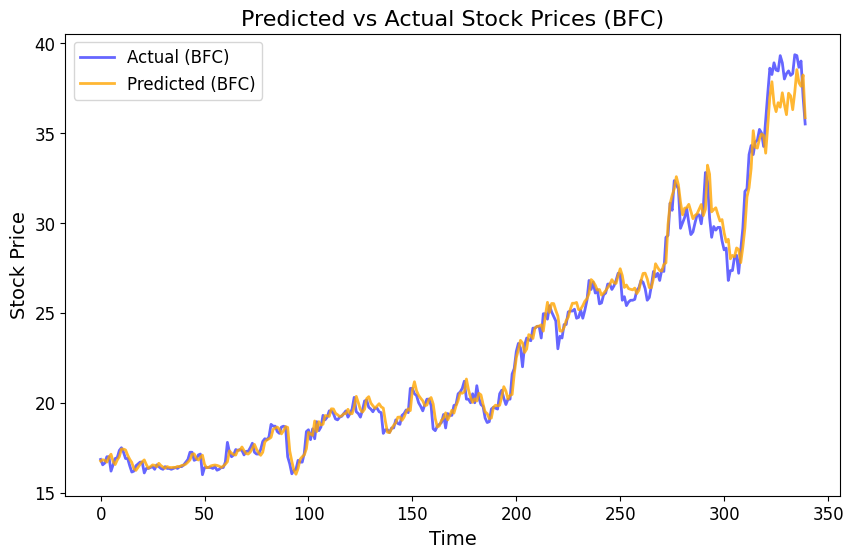

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s, loss=0.00734]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
RMSE: 0.4511080823334123
MAE: 0.3550511360168477
MAPE: 0.8199754549845556
R-squared: -1.0607769307390549
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s, loss=0.00322]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
RMSE: 0.8738830579526513
MAE: 0.7023354756832102
MAPE: 1.6058392645922321
R-squared: -1.2323051709344601
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s, loss=0.00258]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
RMSE: 1.959297152951588
MAE: 1.6930714839696897
MAPE: 4.265898503662391
R-squared: -1.2299603208720344
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s, loss=0.00274]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
RMSE: 0.5936794422172642
MAE: 0.4824227044731385
MAPE: 1.2307532065355309
R-squared: -1.3497018674093444
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s, loss=0.00257]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
RMSE: 0.9418061854888663
MAE: 0.7667865376174461
MAPE: 2.0031657925110866
R-squared: 0.09165354806306136
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock BHN: 1.2090939211247786
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


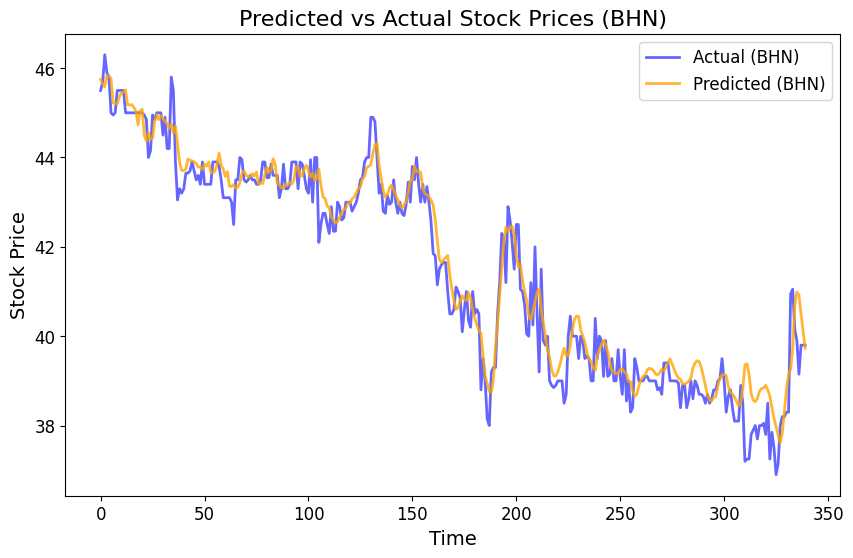

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.00161]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step
RMSE: 1.700501644163329
MAE: 1.5493331995606396
MAPE: 5.3849934041729925
R-squared: -2.434737904504313
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s, loss=0.00338]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
RMSE: 0.6176317161919629
MAE: 0.47641233861446486
MAPE: 1.7134937993067767
R-squared: 0.5761309080496071
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s, loss=0.00197]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
RMSE: 0.3958455195195636
MAE: 0.32936433009803323
MAPE: 1.2930012485908278
R-squared: 0.7133360045073869
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s, loss=0.00168]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
RMSE: 0.28773510573208066
MAE: 0.20895670473575603
MAPE: 0.7421358336795225
R-squared: 0.8688058693687538
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s, loss=0.00127]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
RMSE: 1.3902864417434395
MAE: 1.1203918144106861
MAPE: 3.445603048713275
R-squared: 0.598170801615691
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock BIC: 1.0891112670276826
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


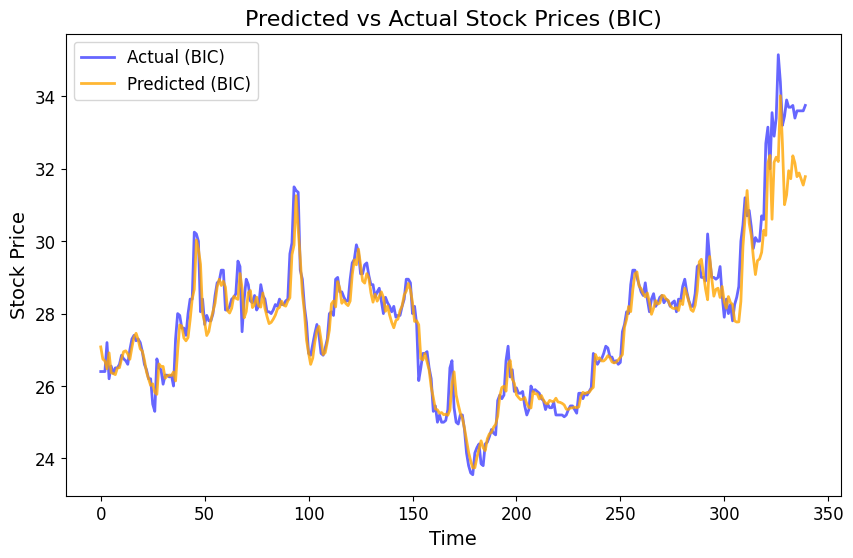

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.00365]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
RMSE: 1.8135719828815169
MAE: 1.7351670996844717
MAPE: 3.9379189927173166
R-squared: -9.012498980856703
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s, loss=0.00289]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
RMSE: 1.0197759065217
MAE: 0.8546083980798727
MAPE: 1.8367896715345544
R-squared: 0.17657227448003487
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s, loss=0.00201]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
RMSE: 1.2419024679670099
MAE: 0.8670357895642512
MAPE: 2.1422020365412897
R-squared: 0.2611720865893584
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s, loss=0.00245]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
RMSE: 1.6275744208390217
MAE: 1.3518659877777137
MAPE: 2.6288190102775655
R-squared: 0.4936431967863858
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s, loss=0.00264]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
RMSE: 0.8725537134234903
MAE: 0.5677343806624389
MAPE: 1.1675296727850712
R-squared: 0.15276118201794686
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE for stock BID: 1.8563312909472203
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


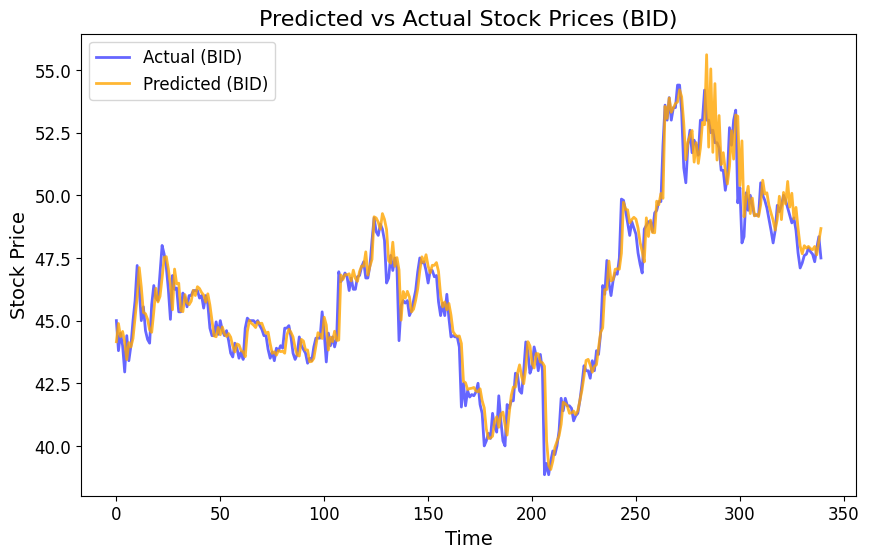

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.44it/s, loss=0.00073]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
RMSE: 0.4694663118468846
MAE: 0.36024960703030234
MAPE: 7.7438983285991885
R-squared: -0.12404151538278807
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s, loss=0.00248]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
RMSE: 0.11579244512796671
MAE: 0.08492562705278392
MAPE: 1.7531504623878706
R-squared: 0.4269749700716904
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s, loss=0.00161]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 0.13391633077491324
MAE: 0.10282214613258815
MAPE: 2.3575937977575014
R-squared: -0.2258140985370578
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s, loss=0.00213]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step
RMSE: 0.16440744971190224
MAE: 0.1055278758853673
MAPE: 2.241532763811373
R-squared: 0.6929643178316329
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s, loss=0.00216]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step
RMSE: 0.08581390791810542
MAE: 0.06117187709361295
MAPE: 1.4650403570918502
R-squared: 0.31768763362654784
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock BKG: 0.05722678565379884
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


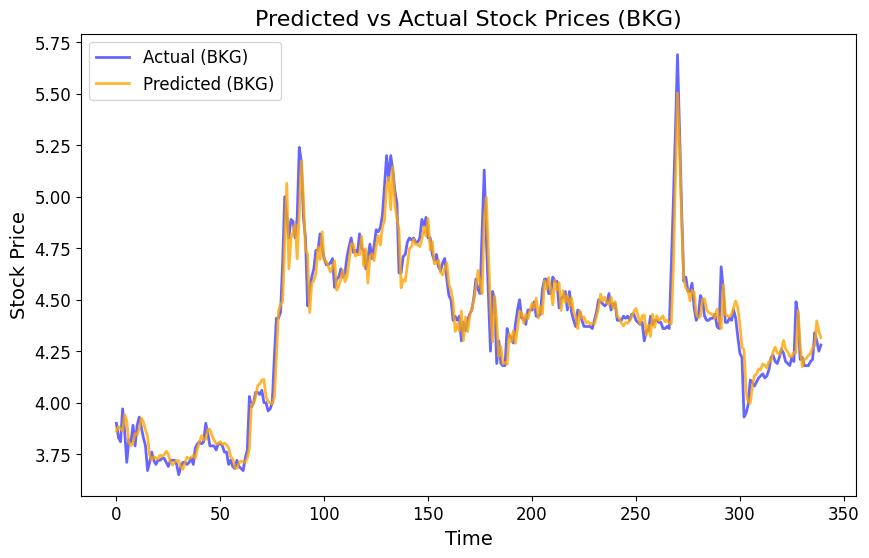

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.38it/s, loss=0.000247]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
RMSE: 0.6618195222736749
MAE: 0.5832418396230781
MAPE: 4.198860313483302
R-squared: -4.283634930544426
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s, loss=0.000408]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step
RMSE: 0.6299547406257587
MAE: 0.5075267882272598
MAPE: 3.303893343237908
R-squared: -0.5491183594585853
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s, loss=0.000613]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
RMSE: 0.5070086610854226
MAE: 0.37848762575537
MAPE: 2.640022174401493
R-squared: 0.41491343481135134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.27it/s, loss=0.000835]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step
RMSE: 1.2374634219000145
MAE: 1.1514550918340674
MAPE: 5.850495148944359
R-squared: -3.192227008529172
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s, loss=0.00137]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
RMSE: 0.6201799008813845
MAE: 0.5017151110246781
MAPE: 2.8622214730739204
R-squared: 0.013960719854527626
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE for stock BMC: 0.6015689335425584
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


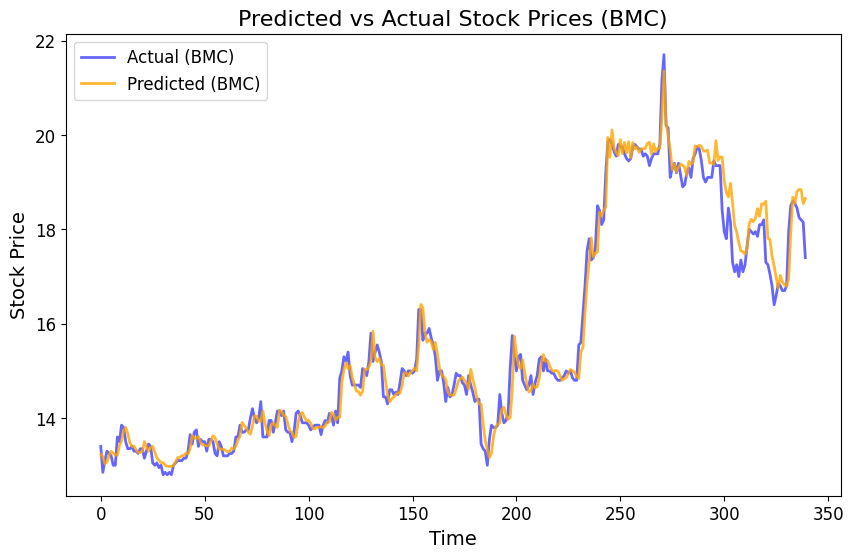

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s, loss=0.00443]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
RMSE: 1.2775345488743834
MAE: 1.109688073396682
MAPE: 4.656703839686028
R-squared: -3.222771336734511
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s, loss=0.00302]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step
RMSE: 0.45187553107230716
MAE: 0.3466653823852536
MAPE: 1.2663657376152515
R-squared: 0.857516224087657
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s, loss=0.00292]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
RMSE: 0.746943431298193
MAE: 0.6502567924559115
MAPE: 3.0552216889785955
R-squared: -2.053173323170313
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s, loss=0.00299]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
RMSE: 0.36251565403394737
MAE: 0.2693441724777224
MAPE: 1.1806848366127873
R-squared: 0.7600438684418384
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s, loss=0.00266]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
RMSE: 1.007980509236389
MAE: 0.7595275127887738
MAPE: 2.9962028896490396
R-squared: 0.6164223378058854
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock BMI: 0.7083305630258367
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


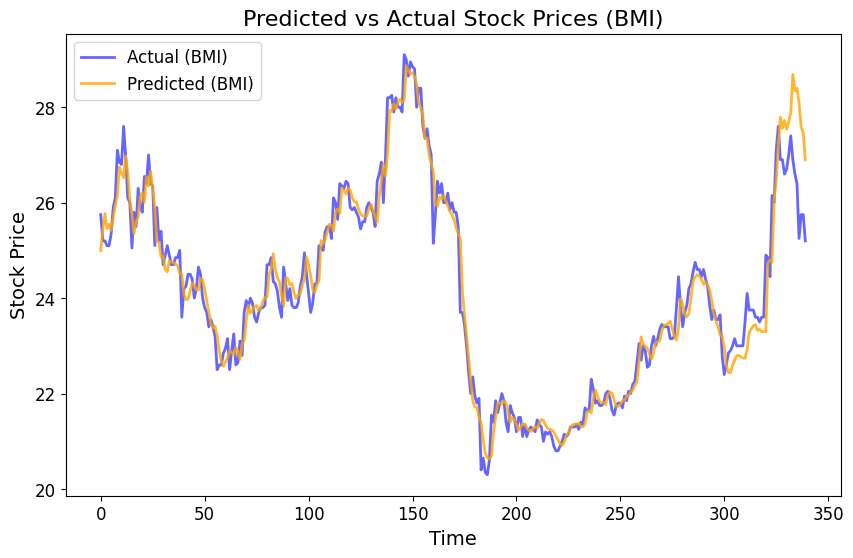

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s, loss=0.000109]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step
RMSE: 14.60538887509972
MAE: 13.133129228949542
MAPE: 15.488483458549734
R-squared: -6.127090566241348
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.82it/s, loss=0.00141]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step
RMSE: 5.658242895703417
MAE: 4.8600077813863765
MAPE: 5.4356914507882435
R-squared: -1.0587103713644157
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s, loss=0.00189]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step
RMSE: 2.904274085323062
MAE: 2.2291029417514796
MAPE: 2.5644585289702193
R-squared: 0.5959846395141595
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s, loss=0.00149]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
RMSE: 3.4457543488566267
MAE: 2.6694297099113435
MAPE: 2.3741278250895648
R-squared: 0.4774441640547441
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s, loss=0.00193]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step
RMSE: 2.6212799789873387
MAE: 1.9307100057601931
MAPE: 1.7209112458866083
R-squared: 0.5146645927348389
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE for stock BMP: 54.50244731664964
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


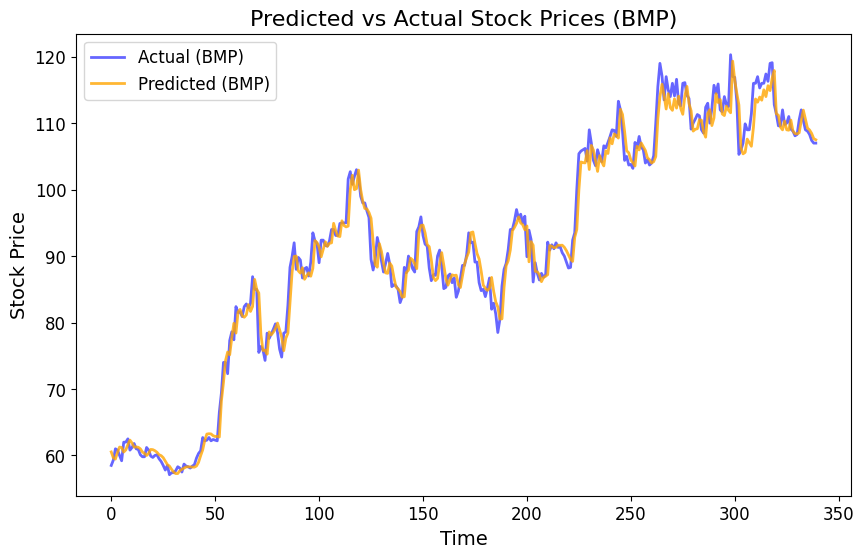

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s, loss=0.00229]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step
RMSE: 2.236328290010026
MAE: 1.6805013443818324
MAPE: 13.388711675398426
R-squared: -4.150827965779859
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.00366]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
RMSE: 0.6158119132057046
MAE: 0.5059955153614271
MAPE: 4.265266652187655
R-squared: -5.9520655370939
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s, loss=0.00264]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
RMSE: 0.3309204627295308
MAE: 0.2569677579700948
MAPE: 2.2068848282173965
R-squared: -0.7714423642200239
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s, loss=0.00215]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
RMSE: 0.5346447491934102
MAE: 0.46217315272241893
MAPE: 3.398279984892938
R-squared: -0.42522772082716487
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s, loss=0.00235]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
RMSE: 0.47797866563121183
MAE: 0.4272985706329342
MAPE: 3.048103246568578
R-squared: 0.40608427167889927
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock BRC: 1.2008410996874084
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


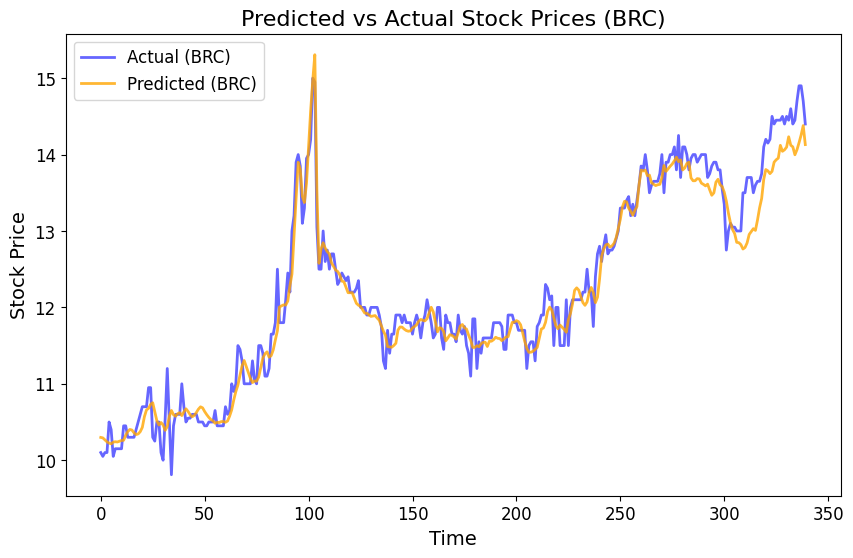

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s, loss=9.17e-5]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
RMSE: 22.31243691848283
MAE: 21.73545910049695
MAPE: 68.74358359187875
R-squared: -115.47915754205329
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s, loss=0.000578]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
RMSE: 2.170941582448245
MAE: 1.7042317125946291
MAPE: 4.6406211124862
R-squared: 0.7493753180308679
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s, loss=0.000806]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
RMSE: 3.590320546282073
MAE: 3.0289630512148142
MAPE: 6.961236128676432
R-squared: 0.22593652606721915
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s, loss=0.00101]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
RMSE: 3.280947169766332
MAE: 2.7293588614463777
MAPE: 4.9500907874699
R-squared: -0.03890752337844772
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it, loss=0.00097]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
RMSE: 2.2030011652949155
MAE: 1.7609401674568659
MAPE: 3.1990129802203353
R-squared: 0.48039748595525067
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock BSI: 106.21321173716444
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


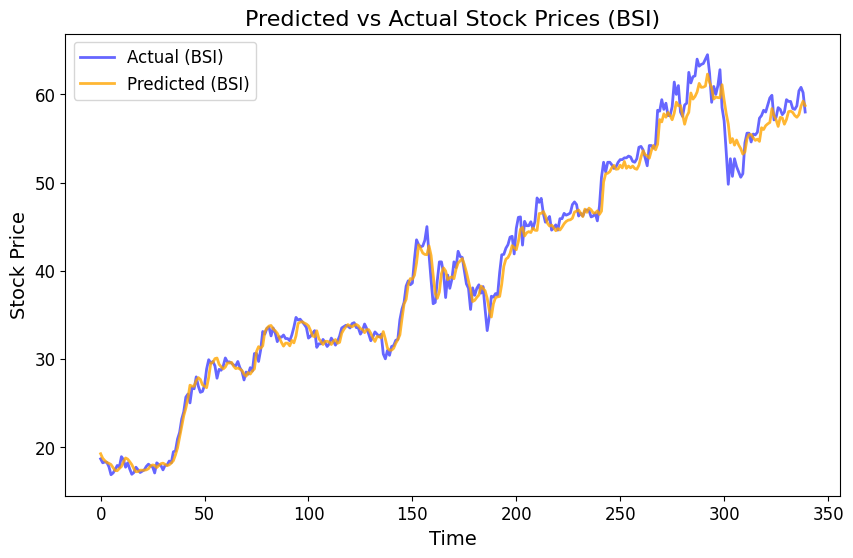

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.52it/s, loss=0.000413]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
RMSE: 1.26796373399589
MAE: 1.1603054127097117
MAPE: 7.556351445648672
R-squared: -0.6662189182255771
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s, loss=0.000799]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step
RMSE: 0.5343191167228837
MAE: 0.3719701744616034
MAPE: 2.4311076415445254
R-squared: 0.28830383024922634
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s, loss=0.00115]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
RMSE: 0.8916921623934935
MAE: 0.5432687560468908
MAPE: 3.4869955718312786
R-squared: 0.585202185538666
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s, loss=0.00124]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step
RMSE: 1.678193064485584
MAE: 1.2226466470956805
MAPE: 6.587887530539309
R-squared: -0.3379606755228095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s, loss=0.00158]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
RMSE: 0.3689276177044033
MAE: 0.31351308584213305
MAPE: 2.2187027169729125
R-squared: -1.5527152663002473
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock BTP: 1.1281566820981737
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


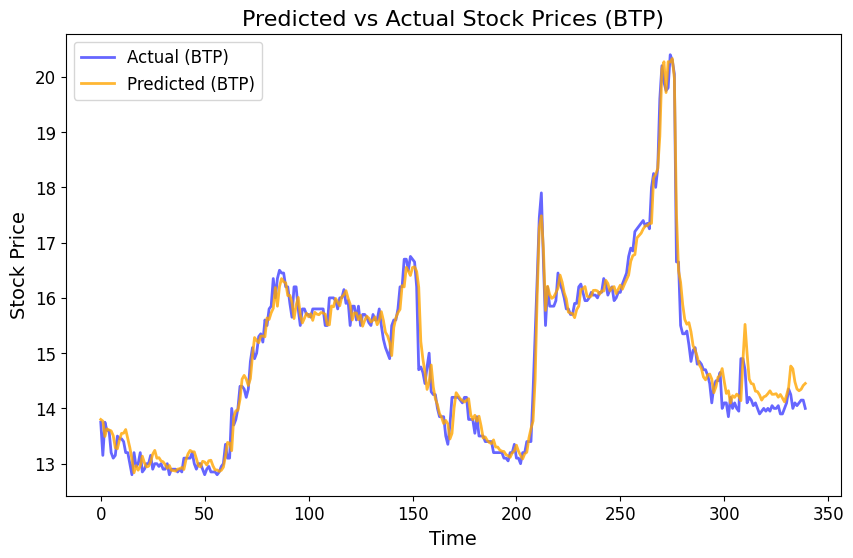

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s, loss=0.00444]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
RMSE: 2.8255879739595455
MAE: 2.027396893203258
MAPE: 6.4025438259919865
R-squared: -1.1247464867428185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s, loss=0.00645]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
RMSE: 1.7363468615190885
MAE: 1.4453673267364502
MAPE: 4.588379455863783
R-squared: -7.114147961280736
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.00424]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
RMSE: 0.9082778593863147
MAE: 0.7341971606016162
MAPE: 2.3984275874836176
R-squared: -0.45851217463276606
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s, loss=0.00328]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
RMSE: 1.0707130424014912
MAE: 0.7390672819316386
MAPE: 2.4076601996367413
R-squared: -1.0296346010178166
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s, loss=0.00266]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
RMSE: 1.2512810520028987
MAE: 0.9490912450850033
MAPE: 2.7935853067689873
R-squared: 0.2837153323585958
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE for stock BTT: 2.9071894364427044
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


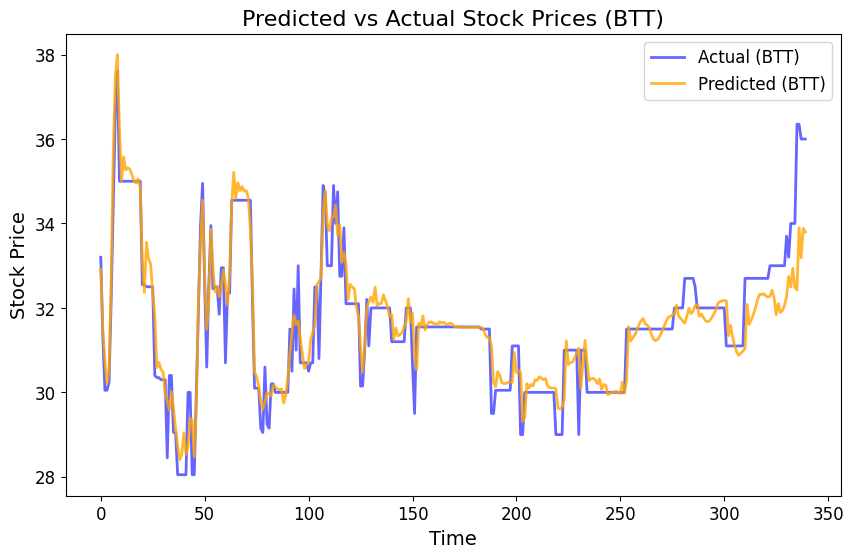

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s, loss=0.0076]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
RMSE: 2.9117248538205915
MAE: 2.847240581661466
MAPE: 6.397765025152356
R-squared: -14.068233581012247
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s, loss=0.00436]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
RMSE: 0.8723413105679995
MAE: 0.5998966012895115
MAPE: 1.3141837262362237
R-squared: 0.45803050913503673
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s, loss=0.00375]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
RMSE: 1.1751761469264805
MAE: 1.049066297896208
MAPE: 2.6281710367385442
R-squared: -2.0208206842834557
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s, loss=0.00272]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
RMSE: 0.7189159136136227
MAE: 0.5270414557307948
MAPE: 1.2334122709244602
R-squared: 0.608586059915911
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s, loss=0.00231]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
RMSE: 0.8718799766961107
MAE: 0.6184571359306575
MAPE: 1.4255289809744243
R-squared: 0.9056075690592978
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock BVH: 2.3794349494791063
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


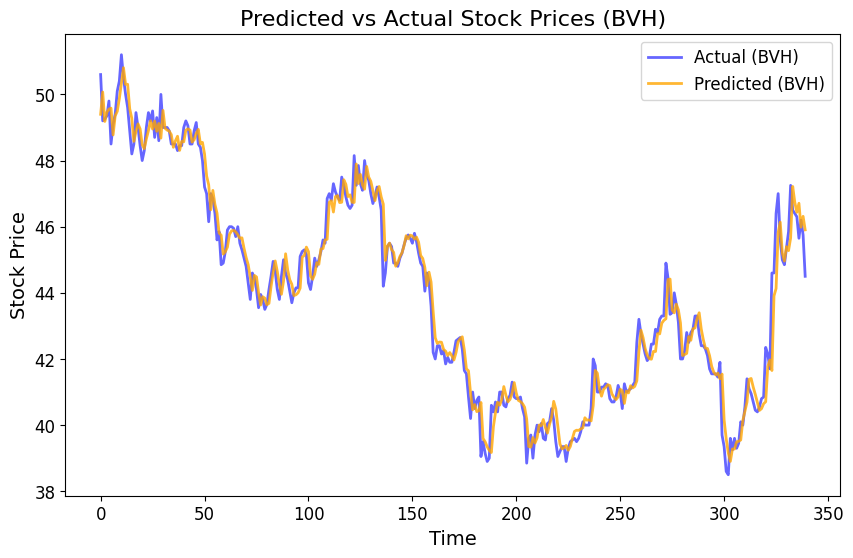

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s, loss=0.00316]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
RMSE: 1.1917295073974208
MAE: 0.8801101576536888
MAPE: 1.9198686102173421
R-squared: -0.322279620184182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s, loss=0.0034]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
RMSE: 0.7589489511040691
MAE: 0.6024835121631634
MAPE: 1.2823949990883061
R-squared: 0.36941545619862626
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.85it/s, loss=0.00309]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step
RMSE: 1.0855023488957485
MAE: 0.9971614878624695
MAPE: 2.315411081479434
R-squared: -0.39219320603760144
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s, loss=0.00306]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
RMSE: 0.42495061854605065
MAE: 0.30623029973357935
MAPE: 0.7151033196537623
R-squared: 0.7591503741753575
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s, loss=0.00292]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
RMSE: 1.2431510625286266
MAE: 0.852867355309427
MAPE: 1.9594765742695883
R-squared: 0.48043104751989507
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock BWE: 0.9801091342221155
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


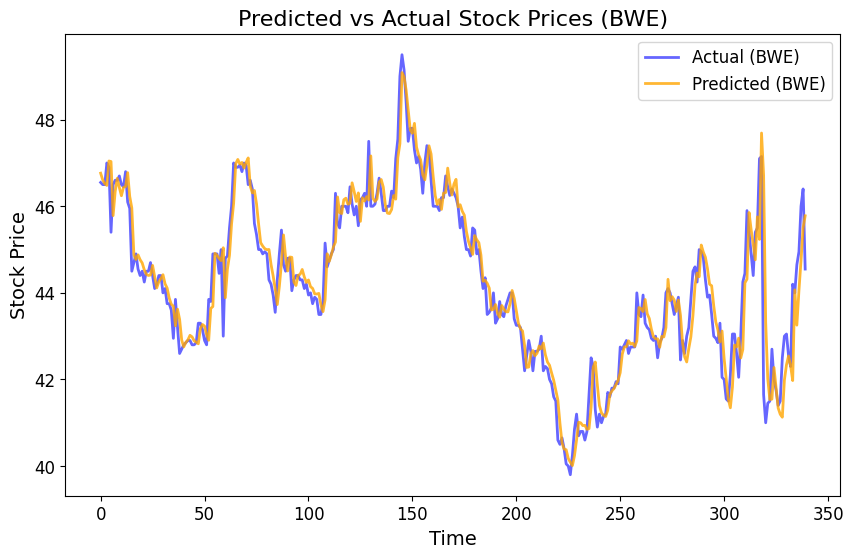

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s, loss=0.00487]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
RMSE: 0.656163400392382
MAE: 0.5582301843166352
MAPE: 2.8955697296581153
R-squared: -2.6364054730953836
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s, loss=0.00513]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
RMSE: 0.18804921348735074
MAE: 0.14815681546926465
MAPE: 0.7927197153450286
R-squared: 0.6329548445725719
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s, loss=0.00388]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
RMSE: 0.20389007551800223
MAE: 0.15642411254346494
MAPE: 0.9326157718900847
R-squared: -0.35631852837639855
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s, loss=0.00306]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
RMSE: 0.5424481652513352
MAE: 0.40917979225516277
MAPE: 2.2445623255043228
R-squared: 0.4074987409660056
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s, loss=0.00354]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
RMSE: 0.23140127593077864
MAE: 0.16866577472537783
MAPE: 0.9714705021108136
R-squared: -1.1107287707274653
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock C32: 0.1710561280178747
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


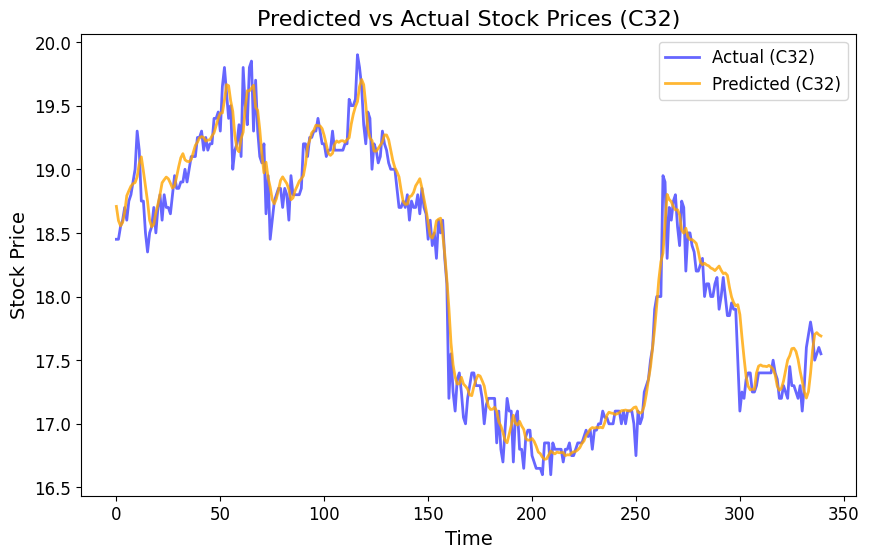

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s, loss=0.00332]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step
RMSE: 0.8800045805528054
MAE: 0.7510278494954112
MAPE: 9.222087268026021
R-squared: -2.6271626256909566
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s, loss=0.00371]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step
RMSE: 0.285122263127446
MAE: 0.18208584630489305
MAPE: 2.4379576463370483
R-squared: 0.520696097592061
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s, loss=0.00325]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step
RMSE: 0.2544278248858808
MAE: 0.19728571277856813
MAPE: 2.8645236537936847
R-squared: 0.7230722716158712
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s, loss=0.00321]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
RMSE: 0.057327903248225974
MAE: 0.046196887016296276
MAPE: 0.6776310656111747
R-squared: 0.5753753686051919
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s, loss=0.0028]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
RMSE: 0.15407734228470696
MAE: 0.13493129095435108
MAPE: 2.2938794522654264
R-squared: 0.21294220833582045
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock C47: 0.18949252013947052
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


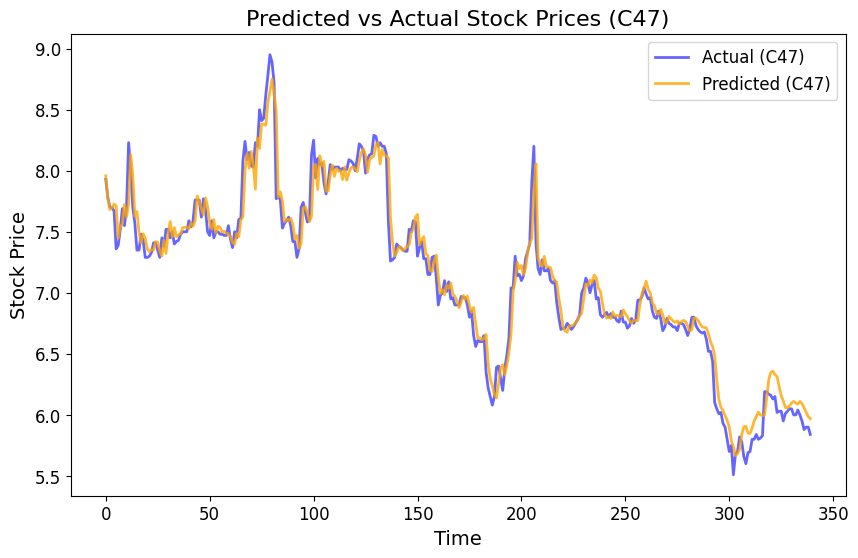

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s, loss=0.000954]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
RMSE: 2.7730272491670194
MAE: 2.3211263033002636
MAPE: 4.241817251703254
R-squared: -3.642843255784543
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s, loss=0.0011]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
RMSE: 11.373411000093077
MAE: 9.841851929659018
MAPE: 14.439188743633363
R-squared: -11.698314687363968
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s, loss=0.00243]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
RMSE: 1.4853248071478538
MAE: 1.2032103677094075
MAPE: 1.797634336371462
R-squared: -1.7712470578178698
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s, loss=0.00206]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
RMSE: 1.4571988603416166
MAE: 1.2328318266570437
MAPE: 1.7297461136236398
R-squared: -0.8717794677619846
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it, loss=0.00197]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
RMSE: 1.8643180118952885
MAE: 1.596650092601767
MAPE: 2.250746630169714
R-squared: -0.08029539879821712
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock CAV: 28.969891570489587
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


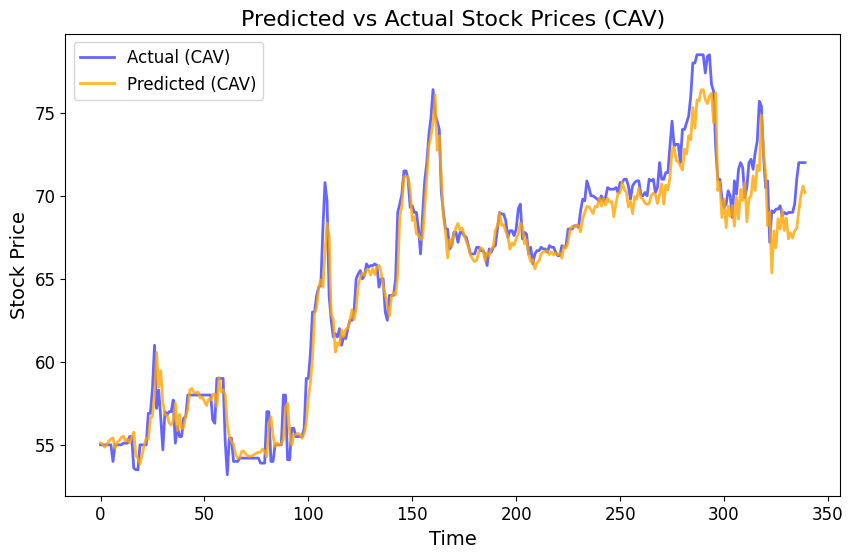

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s, loss=0.00661]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step
RMSE: 1.1898813967239368
MAE: 1.0939362822100525
MAPE: 4.557467531170641
R-squared: -1.506870414359184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s, loss=0.00555]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
RMSE: 1.1868209749962262
MAE: 0.8755523241311307
MAPE: 4.105753873489086
R-squared: -0.23315811393638985
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s, loss=0.00405]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
RMSE: 1.084796230294805
MAE: 0.886772150387988
MAPE: 4.103694537211697
R-squared: 0.2804861672785067
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.18it/s, loss=0.0033]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
RMSE: 1.1310020861717252
MAE: 0.8910315835662186
MAPE: 3.7991865730650756
R-squared: 0.4493697385545483
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it, loss=0.00297]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
RMSE: 1.1211703390378982
MAE: 0.8125735455006362
MAPE: 3.7527297916113755
R-squared: -0.1989649259804489
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock CCI: 1.3074666548571339
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


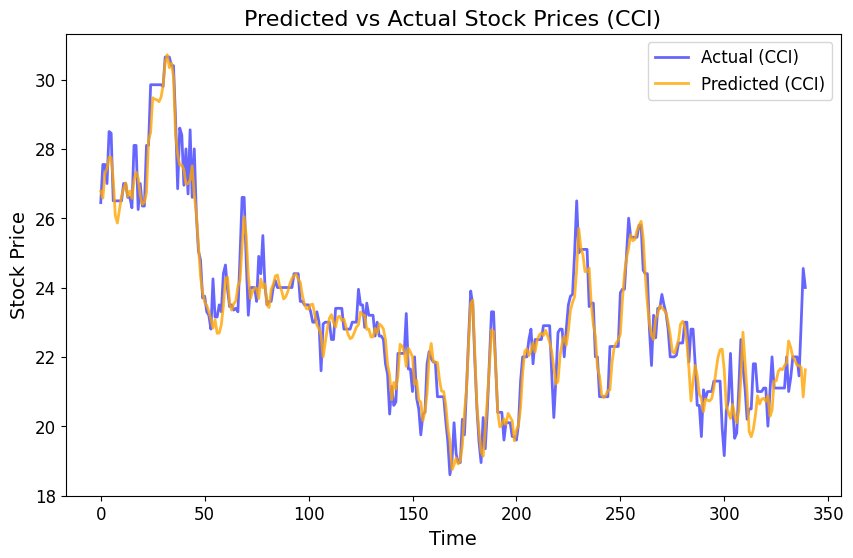

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s, loss=8.59e-5]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
RMSE: 1.020842594656889
MAE: 1.0021570690246302
MAPE: 14.241394524496412
R-squared: -6.838491474669305
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s, loss=0.000576]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step
RMSE: 0.3909998106933309
MAE: 0.3257254180312158
MAPE: 3.971141508444319
R-squared: 0.2598172940139095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s, loss=0.00128]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
RMSE: 0.14062079176276535
MAE: 0.0993042871840298
MAPE: 1.517437560793293
R-squared: 0.8430942259852173
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.06it/s, loss=0.000891]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step
RMSE: 0.26621644858181037
MAE: 0.17048315173387546
MAPE: 1.9577387167071116
R-squared: 0.9009760357071116
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s, loss=0.000901]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
RMSE: 0.38282697371774493
MAE: 0.2674977255538108
MAPE: 2.8068170956330714
R-squared: 0.9278858899224721
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock CCL: 0.28644047028108316
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


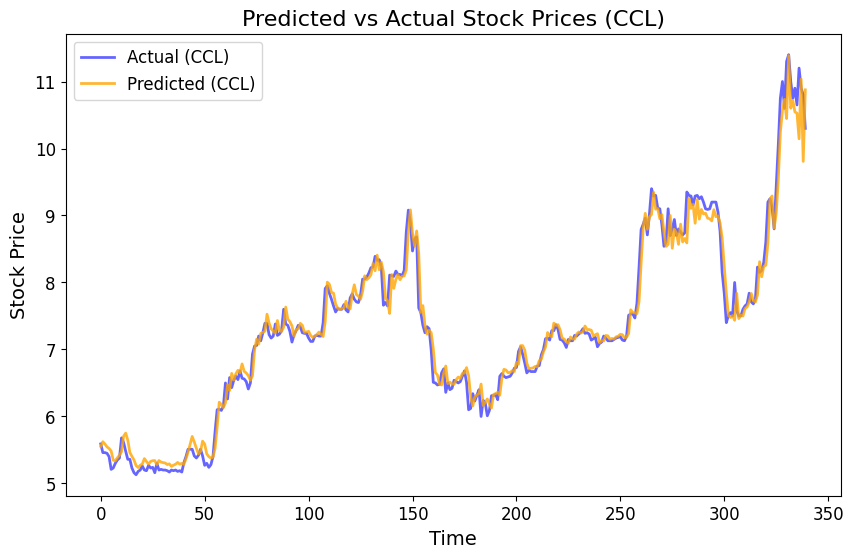

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s, loss=0.00179]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
RMSE: 0.855444214256969
MAE: 0.7853863879386335
MAPE: 4.179941462743399
R-squared: -17.038140285459182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s, loss=0.00242]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step
RMSE: 0.16374836721338068
MAE: 0.13488501835614483
MAPE: 0.7042707069989207
R-squared: 0.9243754036919305
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s, loss=0.0017]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step
RMSE: 0.3569498222688567
MAE: 0.31338217929005524
MAPE: 1.5603570785498324
R-squared: -3.9194276300296664
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s, loss=0.00221]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
RMSE: 0.13023984184221526
MAE: 0.11554600954055819
MAPE: 0.5709245107859454
R-squared: -0.9416824356956717
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s, loss=0.00217]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step
RMSE: 0.14455471158175764
MAE: 0.1160058780014503
MAPE: 0.5904694246975934
R-squared: -0.03517929947445664
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock CDC: 0.184773997626422
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


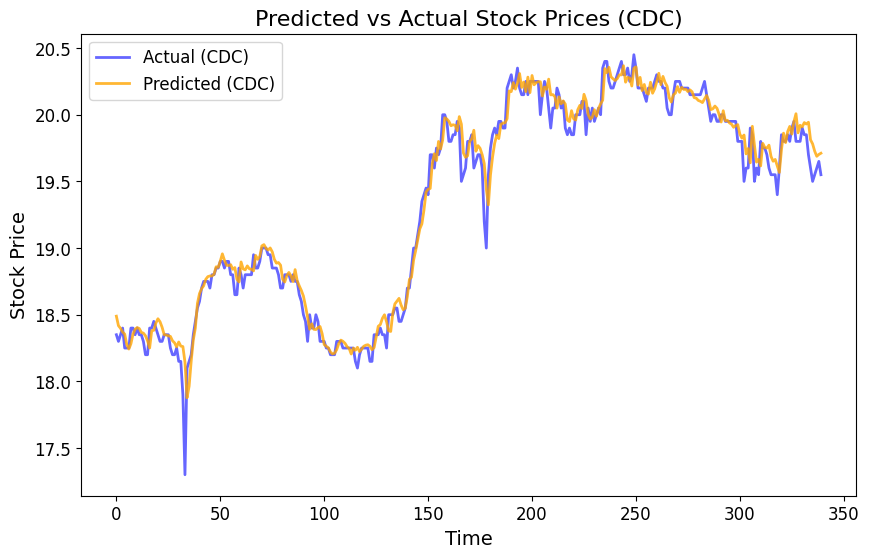

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s, loss=0.000346]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 0.9771037326840616
MAE: 0.7408931493759147
MAPE: 3.1432606462781982
R-squared: -0.4737067455310413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.000295]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step
RMSE: 1.1447524862312615
MAE: 0.9901960659027109
MAPE: 4.249788045960842
R-squared: -37.0463292972644
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s, loss=0.000261]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 0.2250010428111738
MAE: 0.1849218130111688
MAPE: 0.7640086552007952
R-squared: 0.6120607247415074
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s, loss=0.000228]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step
RMSE: 4.86704902828158
MAE: 3.8798257064819355
MAPE: 13.694174708564155
R-squared: -10.913413604614567
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s, loss=0.000372]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step
RMSE: 1.8625466590761985
MAE: 1.5760974884033145
MAPE: 4.833513104587514
R-squared: 0.21944232117490814
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CHP: 5.894612345871296
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


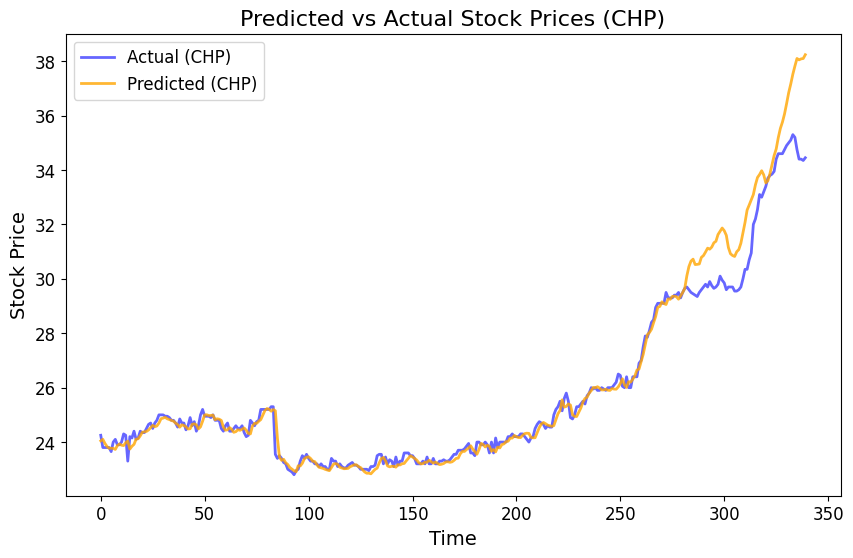

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s, loss=0.00022]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
RMSE: 0.9616296127737647
MAE: 0.9134500490948556
MAPE: 15.031056772332505
R-squared: -0.15687251563695304
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s, loss=0.0019]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
RMSE: 0.8784109549100361
MAE: 0.8200483884811401
MAPE: 11.034508785304665
R-squared: -6.113541123867995
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s, loss=0.00251]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
RMSE: 0.2817017582322791
MAE: 0.23339598594605934
MAPE: 3.76882120393573
R-squared: 0.5966618139665768
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s, loss=0.00244]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
RMSE: 0.06291875360997763
MAE: 0.04495754194259649
MAPE: 0.7416910378591437
R-squared: 0.36402754233775436
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s, loss=0.00176]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
RMSE: 0.23419998871301156
MAE: 0.18491848827526006
MAPE: 3.8231006119892297
R-squared: 0.6684809840276749
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock CIG: 0.36690032054590943
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


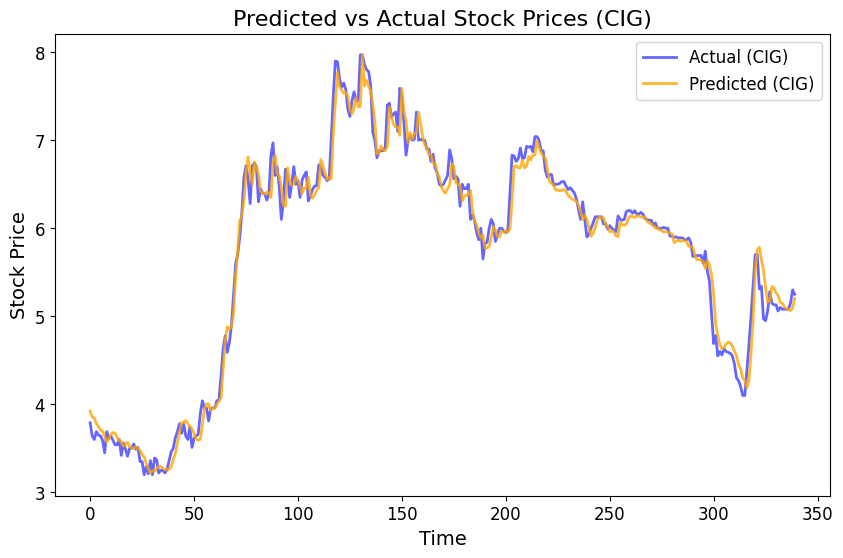

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s, loss=0.00066]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
RMSE: 2.7517277425554116
MAE: 2.0612490380555393
MAPE: 11.826600300188783
R-squared: -2.4681173187145045
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s, loss=0.00132]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
RMSE: 1.0813121434278992
MAE: 0.9221378022432324
MAPE: 4.163400189280789
R-squared: 0.02482278962549689
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s, loss=0.00277]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
RMSE: 0.6726990654952487
MAE: 0.5431110396236184
MAPE: 3.3671884159907517
R-squared: 0.5438201131574196
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s, loss=0.00264]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
RMSE: 0.34279302389909017
MAE: 0.2734572967886925
MAPE: 1.467523118390048
R-squared: 0.17841596060910803
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s, loss=0.00226]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
RMSE: 0.32678028609152965
MAE: 0.2399767735600474
MAPE: 1.4260547686900678
R-squared: 0.6594040176124334
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock CII: 1.8836115932007729
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


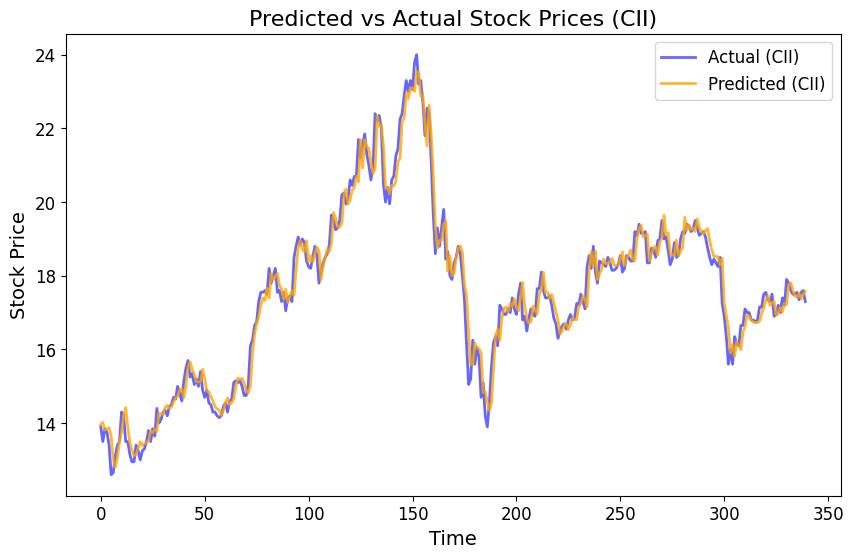

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s, loss=0.0019]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step
RMSE: 2.9447096327966653
MAE: 2.8838959540054203
MAPE: 11.924218415496805
R-squared: -40.099017897747245
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s, loss=0.00173]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
RMSE: 1.6168350686367434
MAE: 1.2832966928184026
MAPE: 4.61862378043926
R-squared: 0.5419407415994177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s, loss=0.00189]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
RMSE: 0.6357477139127153
MAE: 0.46912216395139705
MAPE: 2.1749371493990632
R-squared: -0.014881962330972831
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s, loss=0.00192]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step
RMSE: 0.46594435745138735
MAE: 0.32899760060012373
MAPE: 1.542427800339557
R-squared: 0.6987175350530306
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s, loss=0.00164]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
RMSE: 0.7277788497654563
MAE: 0.4961641300469636
MAPE: 2.258543104110001
R-squared: 0.8960827715454842
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CKG: 2.487282362962203
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


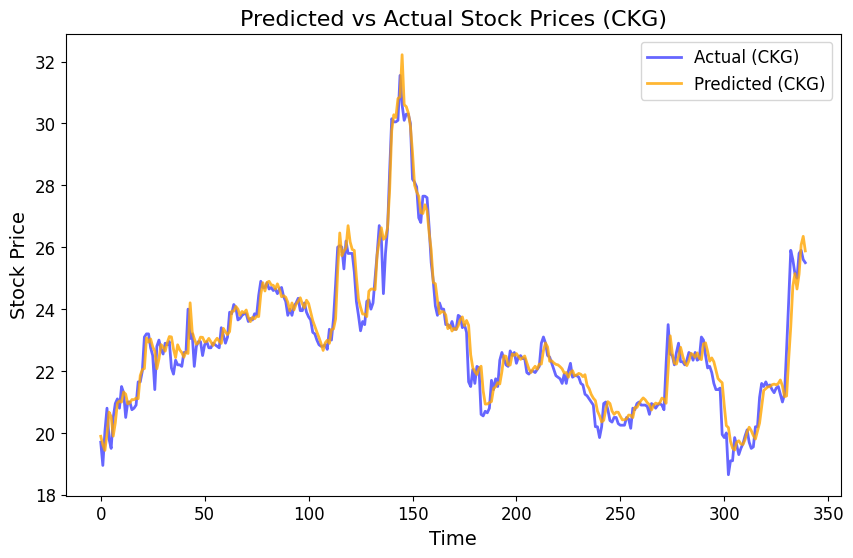

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.96it/s, loss=0.000576]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
RMSE: 0.7191706774774199
MAE: 0.6256097628548746
MAPE: 1.7750215559619327
R-squared: 0.014536874500269859
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s, loss=0.000687]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
RMSE: 0.3710667175943422
MAE: 0.29997942280024237
MAPE: 0.8708603130825578
R-squared: -0.1769834208170511
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s, loss=0.000435]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
RMSE: 0.7647447149100072
MAE: 0.5784551161900163
MAPE: 1.6174166876897063
R-squared: -0.16968357901031372
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s, loss=0.000458]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
RMSE: 1.220851926050779
MAE: 0.9265788435935981
MAPE: 2.353992738414916
R-squared: -0.8212114190394597
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it, loss=0.000695]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
RMSE: 2.6490362690337523
MAE: 2.177801973149181
MAPE: 4.7102902637913076
R-squared: 0.3611585210748197
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock CLC: 1.9495208062461038
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


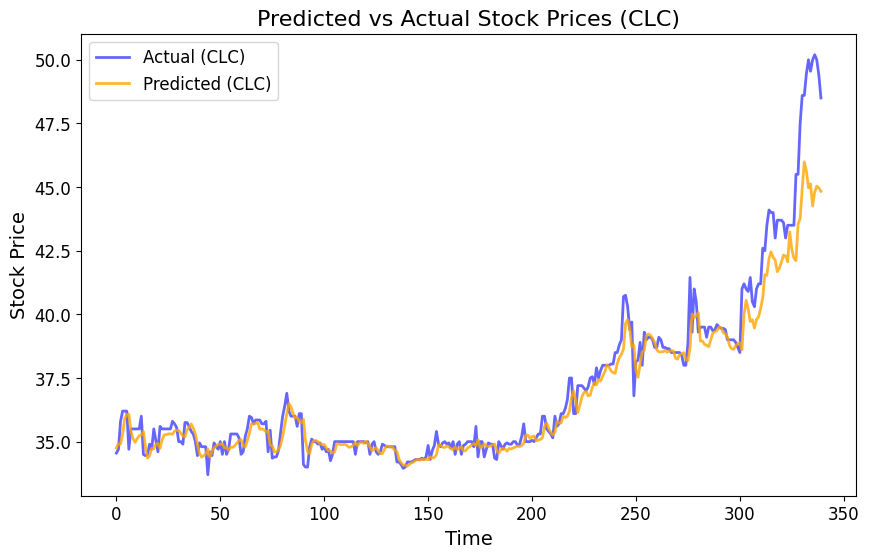

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s, loss=0.000591]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
RMSE: 2.2993481229905637
MAE: 2.0438299518823633
MAPE: 6.3637174241261665
R-squared: -2.5616534050448343
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s, loss=0.000662]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
RMSE: 5.835419563185349
MAE: 5.741751980483533
MAPE: 15.254804698163404
R-squared: -9.080114035369792
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s, loss=0.00172]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step
RMSE: 0.6918744408815428
MAE: 0.5600781944394122
MAPE: 1.6122966393151499
R-squared: 0.10581336238957917
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s, loss=0.00177]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
RMSE: 1.38405122564223
MAE: 1.2615040743350971
MAPE: 3.1081855719785634
R-squared: -0.34901846941351566
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s, loss=0.0016]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step
RMSE: 0.8309362768776103
MAE: 0.6343349212408077
MAPE: 1.6016338964168708
R-squared: -0.4924926761641706
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock CLL: 8.484773280496931
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


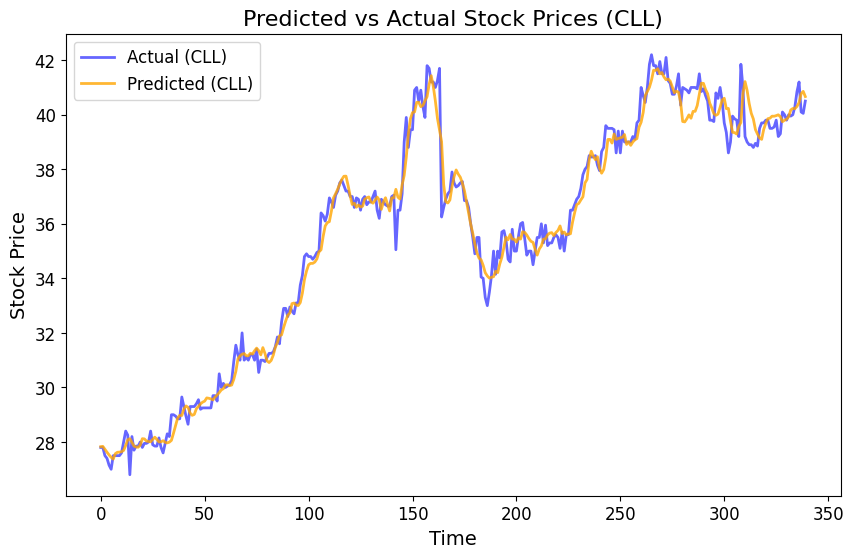

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s, loss=0.00184]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
RMSE: 1.7226390882068816
MAE: 1.3121089673042312
MAPE: 4.246996045632987
R-squared: -0.14411902586730774
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s, loss=0.00178]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
RMSE: 2.711376881924427
MAE: 2.088342397846282
MAPE: 6.9812019174546185
R-squared: -0.4962737360732592
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s, loss=0.00122]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
RMSE: 5.943200433106153
MAE: 4.586298880726101
MAPE: 12.73126163115843
R-squared: -0.2743498754569955
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s, loss=0.00198]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
RMSE: 2.154763873086632
MAE: 2.0282803410291654
MAPE: 5.730875181464066
R-squared: -7.379083632812089
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s, loss=0.00175]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
RMSE: 2.342995962558402
MAE: 1.9486547183990475
MAPE: 4.897527101830415
R-squared: 0.6332175871614183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CLW: 11.154663768289982
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


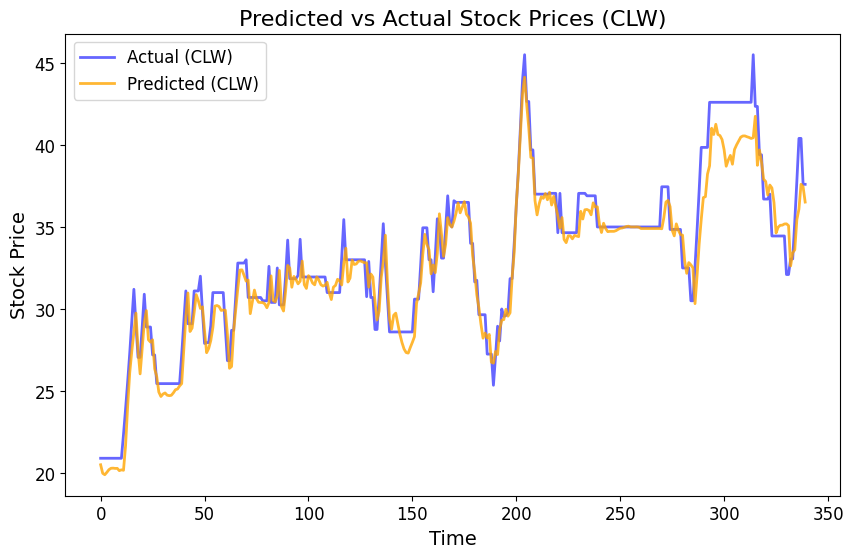

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s, loss=0.000316]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step
RMSE: 1.9801882705153326
MAE: 1.3863747729267923
MAPE: 3.0623049760048464
R-squared: 0.3065128140811927
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s, loss=0.000514]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
RMSE: 4.459512932267797
MAE: 4.252308669462801
MAPE: 8.6010877253238
R-squared: -34.204913423727554
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s, loss=0.0005]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
RMSE: 2.3222804350437882
MAE: 1.2962547243013982
MAPE: 3.1136400338685997
R-squared: 0.6030882418652863
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s, loss=0.000898]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
RMSE: 0.6660554887240061
MAE: 0.46045179403387004
MAPE: 1.1278844480950465
R-squared: 0.19526567673234874
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s, loss=0.000844]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
RMSE: 10.636035551287993
MAE: 7.22542698001489
MAPE: 11.770637743950807
R-squared: -0.3135466020056239
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CMG: 28.55405395221177
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


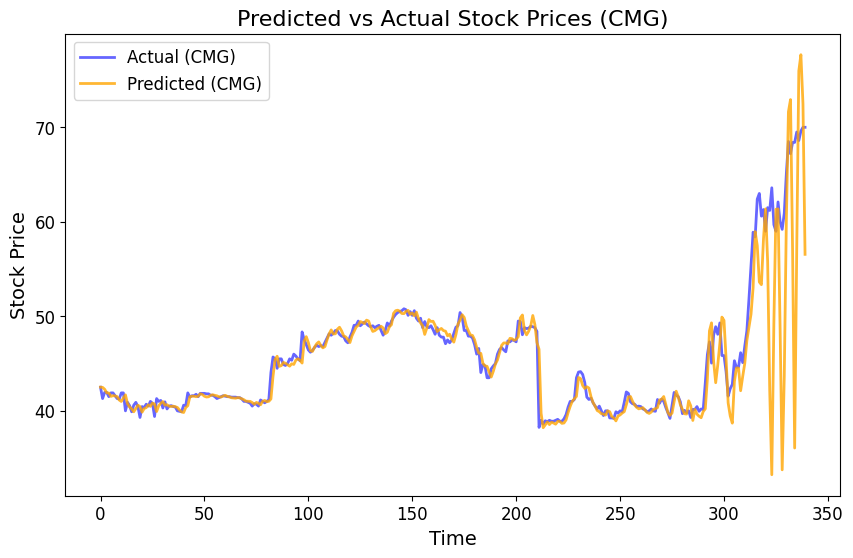

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s, loss=0.00368]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
RMSE: 0.3738794336430555
MAE: 0.28930763188004505
MAPE: 3.067753718452999
R-squared: -0.24232055231324412
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s, loss=0.00276]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
RMSE: 0.28014038380260065
MAE: 0.20502078635990606
MAPE: 2.070158474194201
R-squared: 0.043053616395449135
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s, loss=0.00224]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step
RMSE: 0.43383952484460175
MAE: 0.3790270960740744
MAPE: 4.217444608027687
R-squared: -2.0205172026172793
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.00203]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
RMSE: 0.2580798383701034
MAE: 0.21048312947899084
MAPE: 2.3486995320495314
R-squared: -2.753939100372765
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s, loss=0.0021]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
RMSE: 0.6458860289239278
MAE: 0.43122289106249817
MAPE: 4.1352741660969095
R-squared: 0.543309686015861
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock CMV: 0.17805103283759394
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


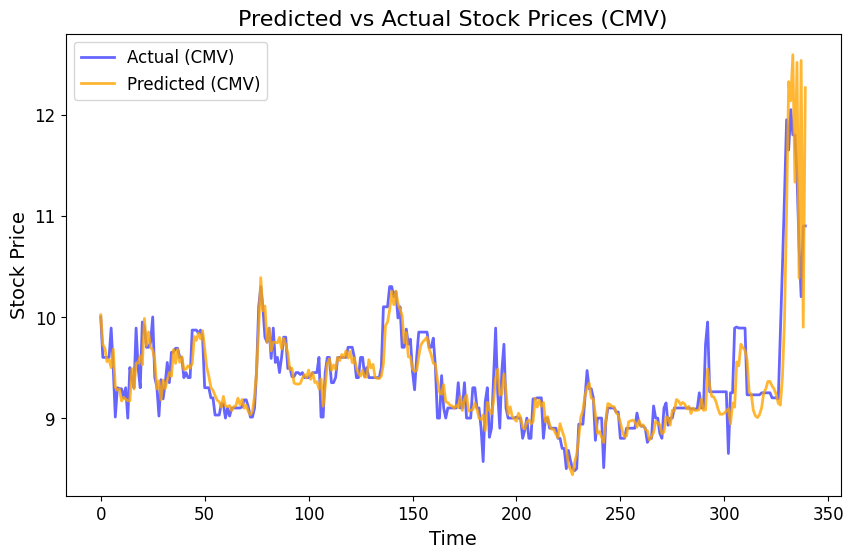

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s, loss=0.00231]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
RMSE: 1.2951303247391455
MAE: 1.2571247869916262
MAPE: 13.511954448048325
R-squared: -10.225377508900857
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.00344]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
RMSE: 1.121291872888612
MAE: 0.9366263510286791
MAPE: 8.686650630594686
R-squared: -6.139667599125805
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s, loss=0.00443]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
RMSE: 0.3213299040512701
MAE: 0.22061813833191932
MAPE: 2.6736187628827133
R-squared: 0.1349527296386719
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s, loss=0.00374]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 0.1089233102789051
MAE: 0.0792818649485704
MAPE: 0.9028127931495035
R-squared: 0.753913903125867
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s, loss=0.00326]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
RMSE: 0.19655128105686834
MAE: 0.13227499597519643
MAPE: 1.4893521073751883
R-squared: 0.9243819967055543
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CMX: 0.6176815246219571
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


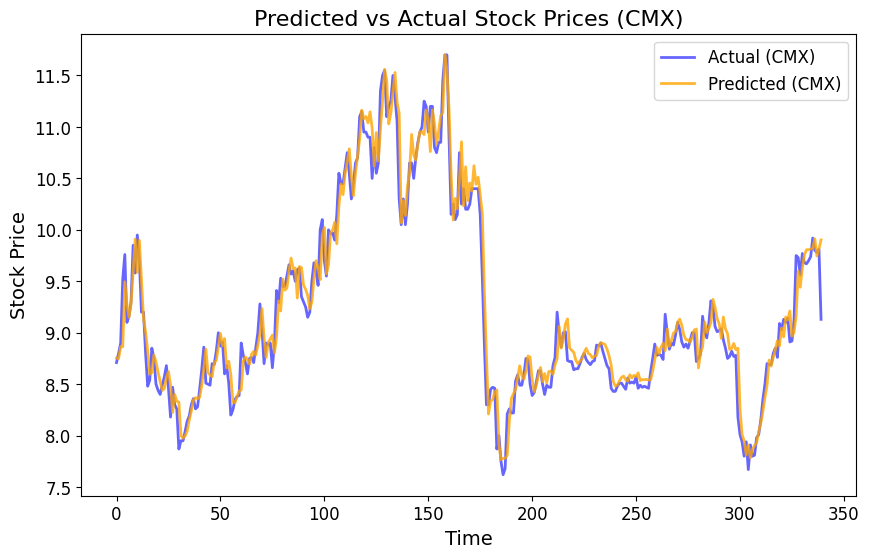

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s, loss=0.000347]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
RMSE: 3.702578478189342
MAE: 3.29630573157221
MAPE: 9.795498570831443
R-squared: -0.8821472906134942
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s, loss=0.00074]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
RMSE: 1.2287412703469238
MAE: 1.000930931866169
MAPE: 3.3659328340520323
R-squared: 0.7429692400945225
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s, loss=0.00294]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
RMSE: 0.8085317632318753
MAE: 0.5613048323243859
MAPE: 2.0338854330594383
R-squared: -0.017359795593615557
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s, loss=0.00196]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
RMSE: 1.2602018769692496
MAE: 0.706780233755708
MAPE: 2.2842661603190364
R-squared: 0.14182665695785712
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s, loss=0.00139]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
RMSE: 1.229171813262403
MAE: 1.0132492551207537
MAPE: 3.0669382643053025
R-squared: 0.38131627949239755
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CNG: 3.7943176451990244
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


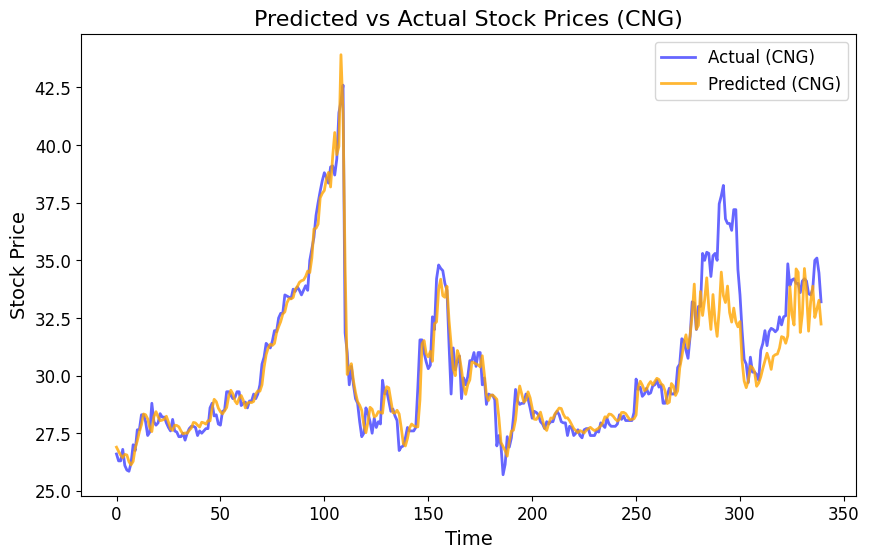

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.78it/s, loss=0.00209]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
RMSE: 1.5768664110119652
MAE: 1.3013765247166154
MAPE: 4.220838046822721
R-squared: -3.106207735327139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s, loss=0.00209]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
RMSE: 1.453246804060501
MAE: 1.1941602949984373
MAPE: 3.6336383263811514
R-squared: -1.3525314250043903
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.0013]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
RMSE: 1.5671814869858034
MAE: 1.3778828468732531
MAPE: 4.700268499446062
R-squared: -0.014114848084844533
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████| 100/100 [4:29:18<00:00, 161.58s/it, loss=0.00117]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
RMSE: 4.053189417266887
MAE: 3.686289535053074
MAPE: 10.349217450452395
R-squared: -15.554990126713623
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s, loss=0.00179]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
RMSE: 0.9437688947893645
MAE: 0.7146027218177908
MAPE: 2.218651812514425
R-squared: -0.06295885227610998
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock COM: 4.874707188771415
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


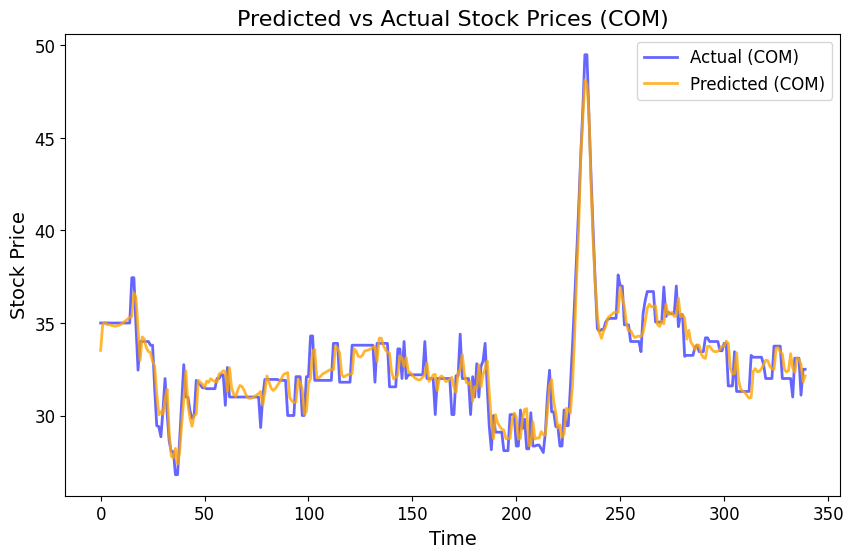

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s, loss=0.000626]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
RMSE: 0.33685562116837564
MAE: 0.29633042830647877
MAPE: 5.219104311623894
R-squared: 0.5608102091113681
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s, loss=0.000835]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
RMSE: 0.1904480552845124
MAE: 0.15308729302883148
MAPE: 2.3406171958212063
R-squared: 0.625207383520467
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00221]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
RMSE: 0.07641819836578016
MAE: 0.05869460159540167
MAPE: 1.0643470842603504
R-squared: 0.8085330806074843
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s, loss=0.00192]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
RMSE: 0.18628963496722153
MAE: 0.13989971844851964
MAPE: 2.0576158680588224
R-squared: 0.8244088288268122
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s, loss=0.00242]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
RMSE: 0.10841606709417821
MAE: 0.0758296951428058
MAPE: 1.228067524242393
R-squared: 0.6757840608442061
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CRC: 0.04040795680324932
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


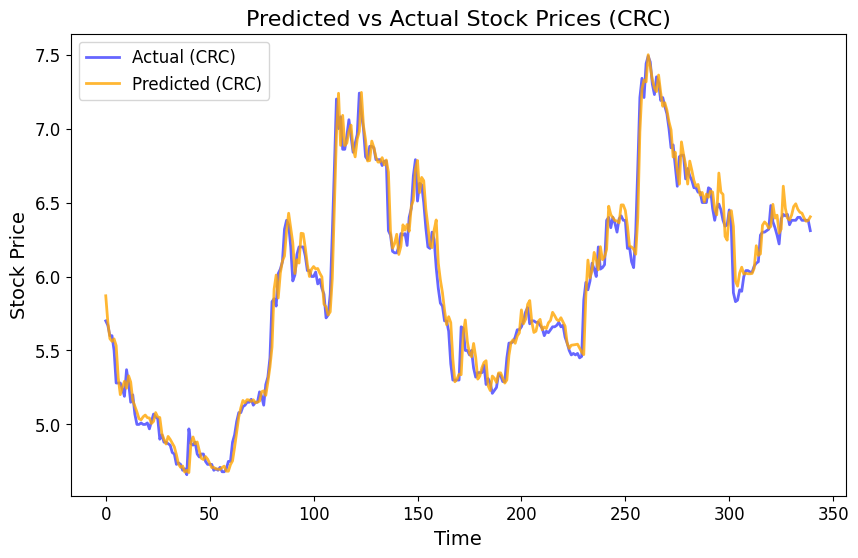

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.95it/s, loss=0.00228]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
RMSE: 2.143402247530773
MAE: 1.9318441915810112
MAPE: 21.817399190040916
R-squared: -14.164568086975015
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s, loss=0.0024]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
RMSE: 0.5436860509648754
MAE: 0.47691799348592845
MAPE: 4.685380026742152
R-squared: -0.3997941090769579
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.96it/s, loss=0.00438]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
RMSE: 0.2683653711634712
MAE: 0.22308800913393462
MAPE: 2.89967322964206
R-squared: 0.5777756268823269
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s, loss=0.00277]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
RMSE: 0.15302177059848146
MAE: 0.11996637299656884
MAPE: 1.3980238031543302
R-squared: 0.38030851963440715
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s, loss=0.00255]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
RMSE: 0.13137204970148517
MAE: 0.09832673436403254
MAPE: 1.200927415168378
R-squared: 0.3565005346202056
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock CRE: 1.0004923933786642
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


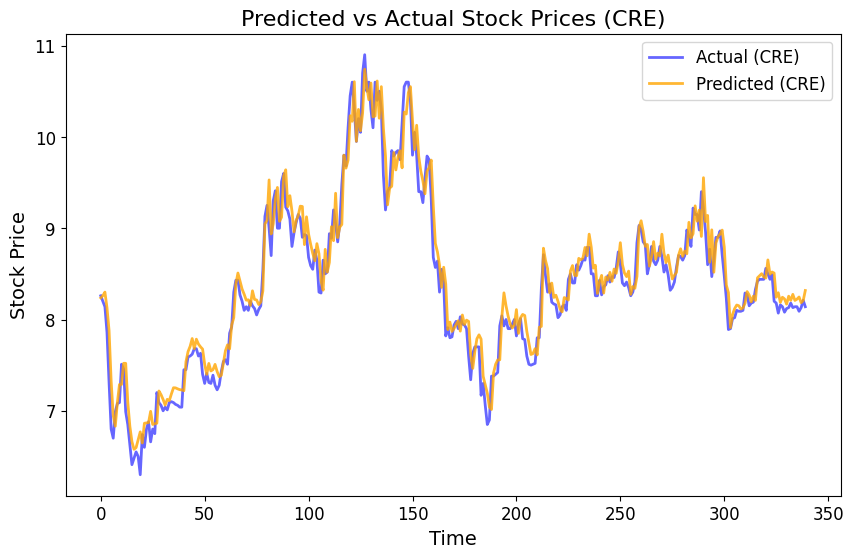

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.06it/s, loss=0.00114]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
RMSE: 0.23232813648449002
MAE: 0.1946908922493452
MAPE: 1.4086381331341786
R-squared: -1.837128147298602
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s, loss=0.000727]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
RMSE: 0.31831061008558886
MAE: 0.2514386102557179
MAPE: 1.8511012431020213
R-squared: 0.4515557657941883
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s, loss=0.000702]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
RMSE: 8.004298089349145
MAE: 7.861191674768925
MAPE: 65.31803165920216
R-squared: -1907.5842607531813
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s, loss=0.000698]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
RMSE: 0.4665450669704444
MAE: 0.30965210612863364
MAPE: 2.30551368066645
R-squared: 0.5303249448270153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s, loss=0.000768]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
RMSE: 0.7281949656987617
MAE: 0.5209864757955082
MAPE: 3.128342747258497
R-squared: 0.5398951985040954
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CSM: 12.99440362364745
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


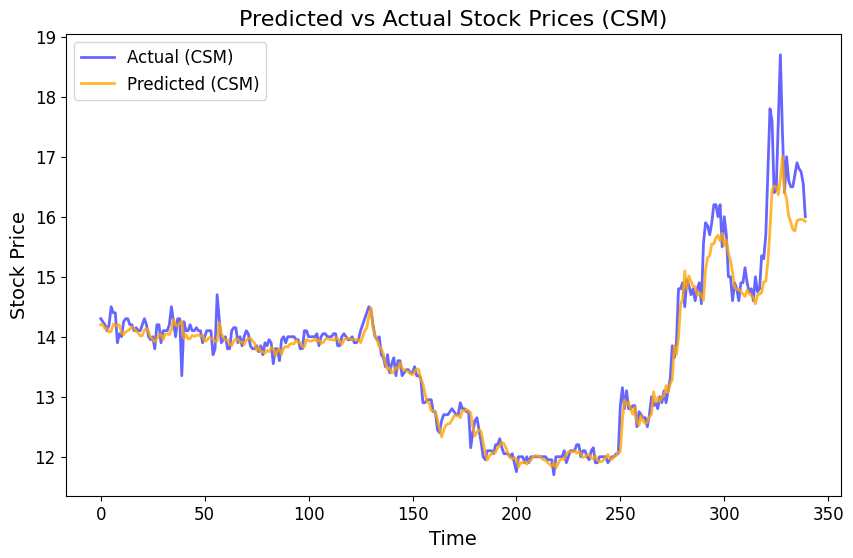

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.13it/s, loss=7.98e-5]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
RMSE: 2.2153115708842095
MAE: 1.796572309667243
MAPE: 5.478121510389254
R-squared: -0.6116963642678943
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s, loss=0.000235]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
RMSE: 1.2543289636358064
MAE: 0.9681093812733886
MAPE: 2.5425960703846218
R-squared: 0.5582857915174128
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s, loss=0.000364]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
RMSE: 1.8004511743076477
MAE: 1.2361107729747889
MAPE: 3.316263408313242
R-squared: 0.2619354610068436
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.000502]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
RMSE: 15.854619600266341
MAE: 12.930505172163246
MAPE: 22.68220867687408
R-squared: -12.293526943692505
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s, loss=0.000795]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
RMSE: 2.1802474954020417
MAE: 1.7337117870897085
MAPE: 2.685324568104802
R-squared: 0.8453043529407374
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CSV: 53.16900254930628
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


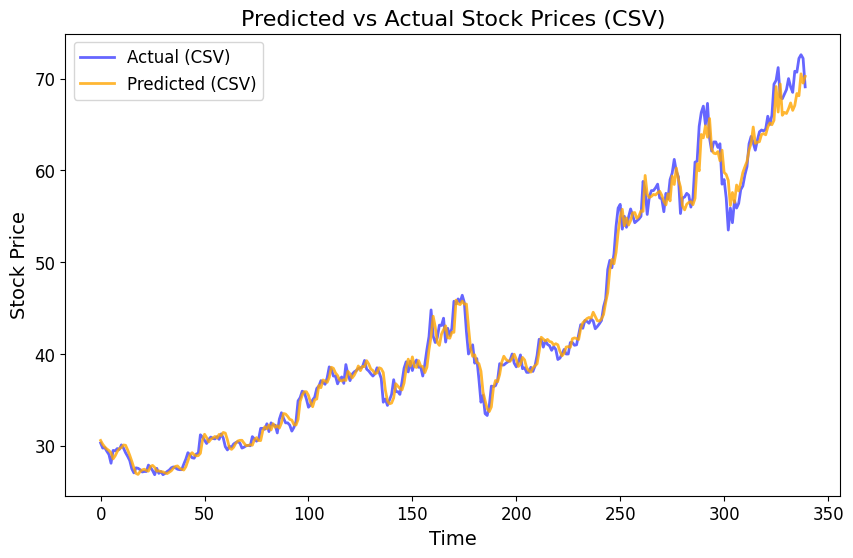

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s, loss=0.000487]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
RMSE: 85.55261996789636
MAE: 77.21063590280713
MAPE: 117.56379568270225
R-squared: -757.0179512645336
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s, loss=0.00313]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
RMSE: 4.218752118741459
MAE: 3.3243546703457865
MAPE: 5.231615671235463
R-squared: -0.3559409801282716
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s, loss=0.00259]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
RMSE: 2.3435756738880937
MAE: 1.9118419571220826
MAPE: 3.24622500440922
R-squared: 0.7587560407989259
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s, loss=0.00253]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
RMSE: 2.4695486393263124
MAE: 1.9590602988004637
MAPE: 2.7956849565519515
R-squared: 0.22442075037774
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s, loss=0.00268]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
RMSE: 1.4077491600865297
MAE: 1.1523961378634013
MAPE: 1.6701729925556468
R-squared: 0.8541685914382133
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE for stock CTD: 1470.124285585929
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


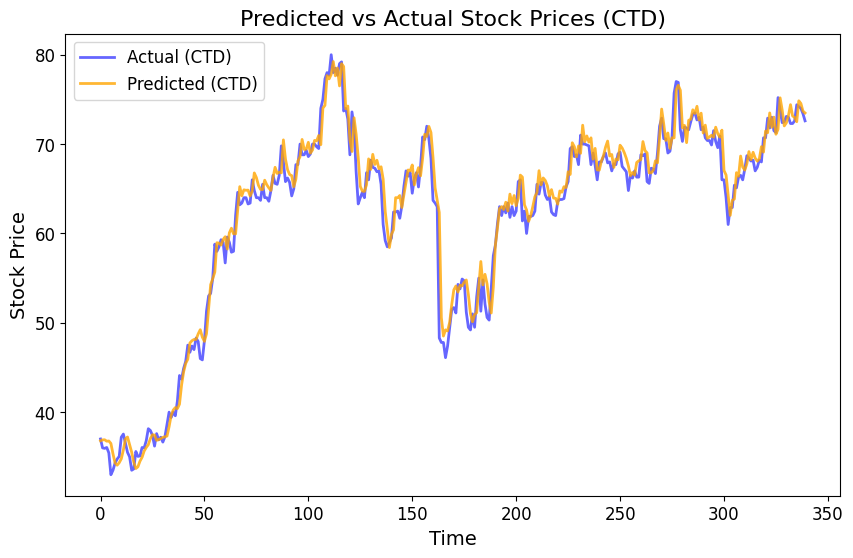

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|███████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s, loss=0.0044]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
RMSE: 1.080362938720828
MAE: 0.7415647563338268
MAPE: 2.0051047762399303
R-squared: -0.3711010887921089
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.44it/s, loss=0.00394]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
RMSE: 1.022644634905617
MAE: 0.8491871221736073
MAPE: 2.7339248220771104
R-squared: -0.1880760075773973
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s, loss=0.00386]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
RMSE: 0.5675421694120635
MAE: 0.49576764064840945
MAPE: 1.6531877636163679
R-squared: 0.3583503498580385
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s, loss=0.00331]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
RMSE: 0.3781251303427893
MAE: 0.3020898831635714
MAPE: 0.9842117084940686
R-squared: 0.6426874567118543
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s, loss=0.00239]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
RMSE: 0.31881473682507716
MAE: 0.18998700596392143
MAPE: 0.6193964962195297
R-squared: 0.6047308807122613
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CTF: 0.5559423386674583
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


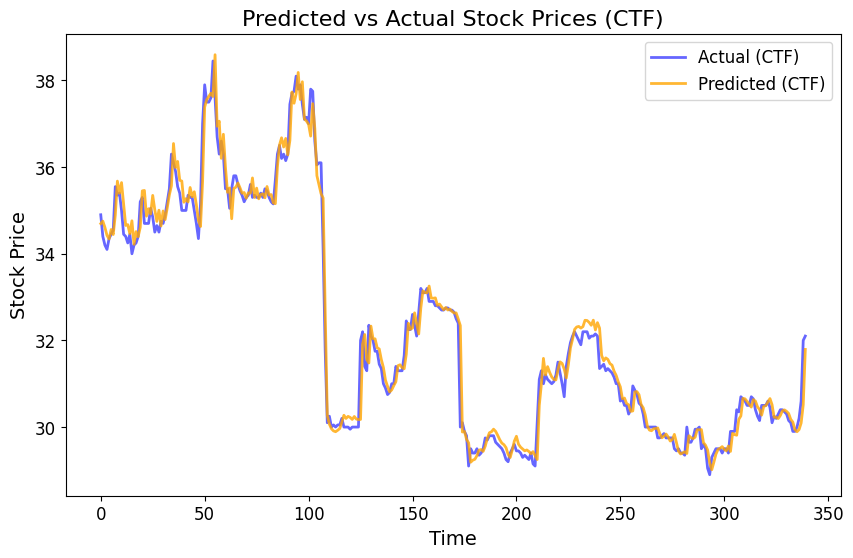

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s, loss=0.00167]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
RMSE: 0.735600958747266
MAE: 0.6075943741202356
MAPE: 2.142427057549323
R-squared: -0.6354568012728781
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.47it/s, loss=0.00164]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
RMSE: 1.2906082261805347
MAE: 1.1846391719579696
MAPE: 3.7029539508930718
R-squared: -1.115203141032881
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s, loss=0.00208]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
RMSE: 0.6330615549670224
MAE: 0.3841880437731747
MAPE: 1.3843757507602446
R-squared: 0.7477963727383715
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s, loss=0.00219]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
RMSE: 0.9148702243539442
MAE: 0.7032248520851125
MAPE: 2.032546553670435
R-squared: 0.7020122497097352
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s, loss=0.00248]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
RMSE: 0.7863974282091534
MAE: 0.5870567762851713
MAPE: 1.806875746514127
R-squared: -0.776441481605129
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CTG: 0.8125907477750869
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


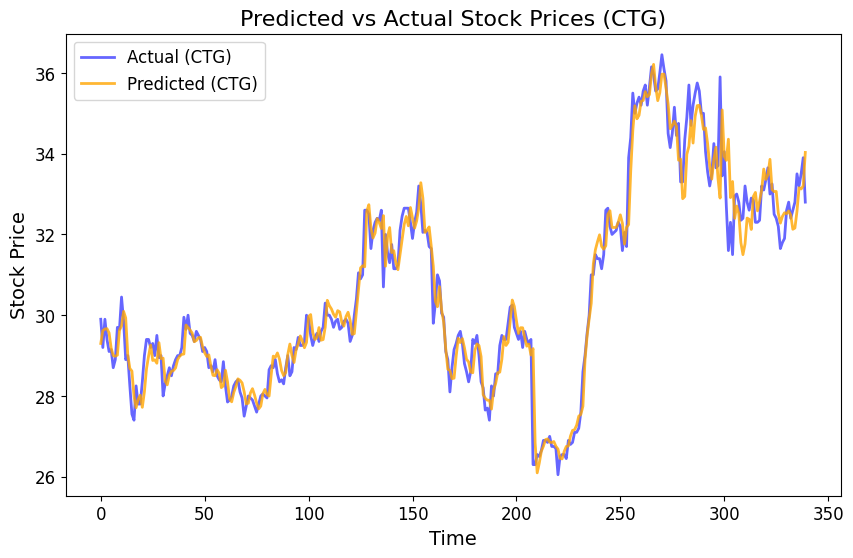

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s, loss=0.000513]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
RMSE: 1.2110787953230409
MAE: 0.9816503112949431
MAPE: 6.789209035935603
R-squared: -0.2686446954101913
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s, loss=0.00173]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
RMSE: 1.1306718239125073
MAE: 0.8532002214342362
MAPE: 5.4347379262830575
R-squared: -1.814970325640508
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s, loss=0.00279]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
RMSE: 0.35588559223101224
MAE: 0.29337563227862173
MAPE: 2.0064303405045623
R-squared: 0.15010311879553606
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s, loss=0.00231]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
RMSE: 0.3478822332554204
MAE: 0.27067937605082937
MAPE: 1.6834064384671228
R-squared: 0.6013581880261543
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s, loss=0.00203]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
RMSE: 0.6739291073309378
MAE: 0.5475175746530286
MAPE: 3.2046867921319855
R-squared: 0.8128478926433812
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CTI: 0.6893975333102031
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


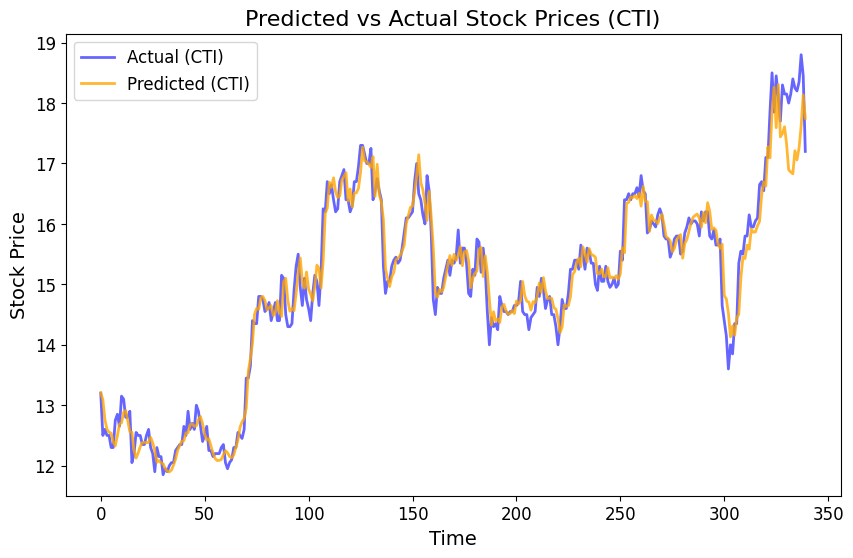

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.34it/s, loss=0.000157]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
RMSE: 9.388114954200052
MAE: 9.099709805343304
MAPE: 12.901154285287515
R-squared: -9.322874489725303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s, loss=0.000228]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
RMSE: 2.5774731763016296
MAE: 1.9547651098668584
MAPE: 2.5334976532077746
R-squared: 0.68798906756241
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s, loss=0.000325]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
RMSE: 2.3414063294803165
MAE: 1.8198608775809402
MAPE: 2.1858205277434095
R-squared: 0.8664302449168569
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s, loss=0.00034]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
RMSE: 2.510335234077934
MAE: 1.609183842092751
MAPE: 1.5307658436434104
R-squared: 0.9134510456934594
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s, loss=0.000387]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
RMSE: 4.081658863764986
MAE: 3.3228470510244406
MAPE: 2.597021688412044
R-squared: 0.624430182755032
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CTR: 24.64479520703279
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


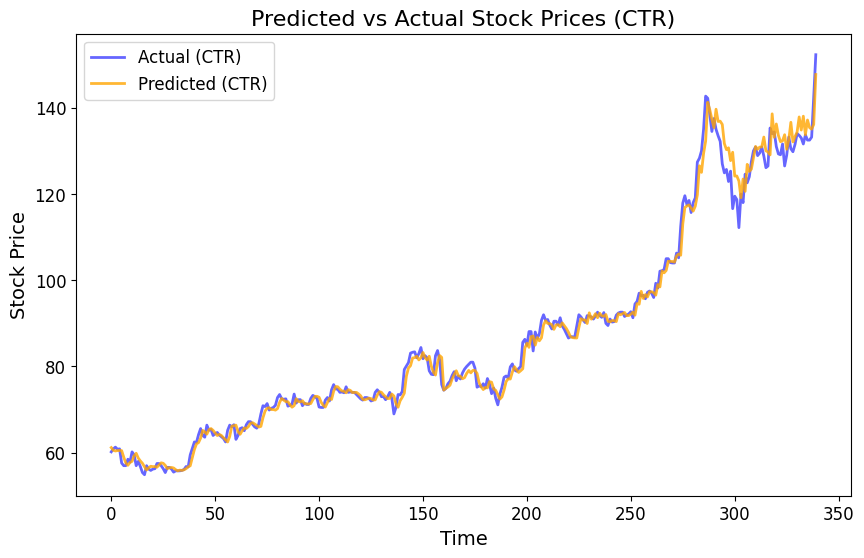

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s, loss=0.000244]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
RMSE: 5.131728503615499
MAE: 4.816457862996032
MAPE: 25.079762124681032
R-squared: -9.900098276001557
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.000331]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
RMSE: 12.618181697709096
MAE: 12.244230014309286
MAPE: 44.55755344627015
R-squared: -20.873096777565618
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s, loss=0.000571]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
RMSE: 1.3614566161469066
MAE: 0.9822260744497175
MAPE: 4.176301647626898
R-squared: 0.6821544301098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, loss=0.000757]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
RMSE: 1.352527365411404
MAE: 1.0790088904649018
MAPE: 3.2987034633691974
R-squared: 0.8170806915294639
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.56it/s, loss=0.000807]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
RMSE: 3.738693127530995
MAE: 3.4461618246138093
MAPE: 8.310579133656262
R-squared: -0.12269668233686515
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE for stock CTS: 40.64277349698099
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


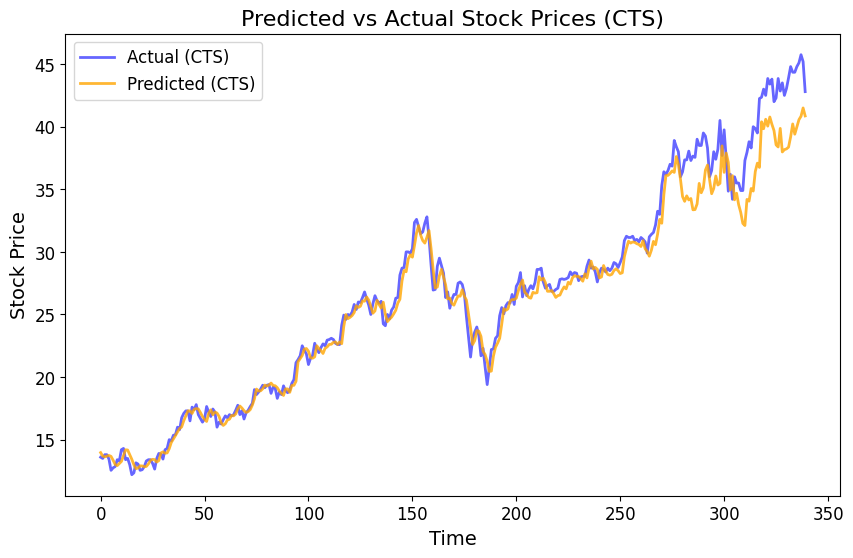

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s, loss=0.00709]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
RMSE: 1.8730721594904032
MAE: 1.3453807198256258
MAPE: 3.5732908831043027
R-squared: -3.4398263149300394
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.00655]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
RMSE: 1.152808029412996
MAE: 0.8701574604958294
MAPE: 2.4000443118004053
R-squared: 0.20736805375058953
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.00484]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
RMSE: 1.744106177417493
MAE: 1.4829500613734137
MAPE: 4.524442025425165
R-squared: -0.9872506843610729
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s, loss=0.00441]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
RMSE: 1.1816692677597738
MAE: 0.8426444944180549
MAPE: 2.6799696819040033
R-squared: 0.43788099328252506
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|██████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s, loss=0.00368]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
RMSE: 1.8283789434619027
MAE: 1.6097994433715932
MAPE: 5.608200623125022
R-squared: -5.51976657130362
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE for stock CVT: 2.5237167689411524
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


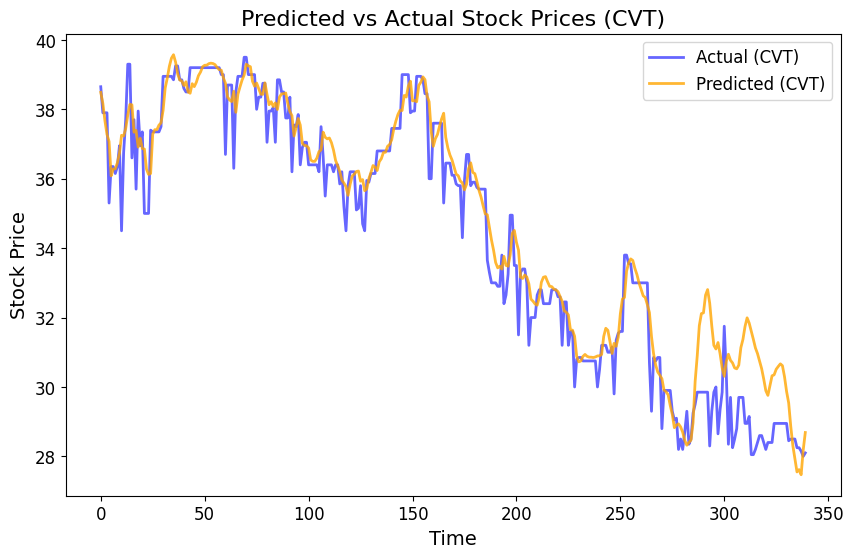

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.07it/s, loss=0.000193]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
RMSE: 9.491875346648582
MAE: 9.264845806285738
MAPE: 32.91210307527691
R-squared: -61.80771023859191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.000309]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
RMSE: 0.6350282191934409
MAE: 0.48132347345352217
MAPE: 1.6611632873174038
R-squared: -0.061077482188025334
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.96it/s, loss=0.000615]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
RMSE: 0.44614479653759764
MAE: 0.36932435318827694
MAPE: 1.4839609990666807
R-squared: -0.18949451296183462
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs: 100%|█████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s, loss=0.000406]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
RMSE: 3.1114502561960866
MAE: 2.1430743148922913
MAPE: 6.229380573455161
R-squared: 0.32939313870748854
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epochs:  22%|████████████▉                                              | 22/100 [00:23<01:16,  1.02it/s, loss=0.00102]

In [ ]:
def main():
    symbols = data['Mã CK'].unique()
    seq_length = 20  
    epochs = 100

    for symbol in symbols:
        stock_data = data[data['Mã CK'] == symbol].copy()
        stock_data_scaled, scaler = prepare_data(stock_data, features)

        if len(stock_data_scaled) < seq_length:
            print(f"Skipping {symbol} due to insufficient data")
            continue

        tscv = TimeSeriesSplit(n_splits=5)
        all_y_test = []
        all_y_pred = []

        for train_index, test_index in tscv.split(stock_data_scaled):
            train_data, test_data = stock_data_scaled.iloc[train_index], stock_data_scaled.iloc[test_index]

            if len(train_ data) < seq_length or len(test_data) < seq_length:
                print(f"Skipping split for {symbol} due to insufficient sequence data")
                continue

            X_train, Y_train = create_sequences(train_data[features].values, seq_length, features.index('Đóng cửa'))
            X_test, Y_test = create_sequences(test_data[features].values, seq_length, features.index('Đóng cửa'))

            lstm_model = train_lstm(X_train, Y_train, seq_length, epochs)
            evaluate_performance(lstm_model, test_data[features].values, scaler, seq_length)

            y_pred = lstm_model.predict(X_test)
            temp = np.zeros((y_pred.shape[0], len(features)))
            temp[:, features.index('Đóng cửa')] = y_pred.flatten()
            y_pred_transformed = scaler.inverse_transform(temp)[:, features.index('Đóng cửa')]
            Y_test_transformed = np.zeros((Y_test.shape[0], len(features)))
            Y_test_transformed[:, features.index('Đóng cửa')] = Y_test.flatten()
            Y_test_transformed = scaler.inverse_transform(Y_test_transformed)[:, features.index('Đóng cửa')]

            all_y_test.extend(Y_test_transformed)
            all_y_pred.extend(y_pred_transformed)

        if len(all_y_test) > 0 and len(all_y_pred) > 0:
            all_y_test = np.array(all_y_test)
            all_y_pred = np.array(all_y_pred)

            mse = mean_squared_error(all_y_test, all_y_pred)
            print(f'MSE for stock {symbol}: {mse}')

            visualize_results(stock_data_scaled[features].values, scaler, lstm_model, symbol, seq_length)

if __name__ == "__main__":
    main()